In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
import numpy as np

from torch.autograd import Variable
from utils import create_dataloader

__Федотова Алёна Дмитриевна__

### Creating config object (argparse workaround)

In [2]:
class Config:
    pass

config = Config()
config.mnist_path = None
config.batch_size = 16
config.num_workers = 3
config.num_epochs = 100
config.noise_size = 50
config.print_freq = 100


### Create dataloder

In [1]:
dataloader = create_dataloader(config)

NameError: name 'MNIST' is not defined

In [4]:
len(dataloader)

3750

In [5]:
for image, cat in dataloader:
    break

In [6]:
cat

tensor([0, 6, 1, 0, 0, 2, 9, 2, 1, 8, 8, 3, 5, 9, 8, 0])

In [6]:
image.size()

torch.Size([16, 1, 28, 28])

In [7]:
28*28

784

### Create generator and discriminator

In [8]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential( 
            nn.Linear(config.noise_size, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Sigmoid())
        
    def forward(self, x):
        return self.model(x)
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1), 
            nn.Sigmoid())
    def forward(self, x):
        return self.model(x)

In [9]:
generator = Generator()
discriminator = Discriminator()

### Create optimizers and loss

In [10]:
optim_G = optim.Adam(params=generator.parameters(), lr=0.0001)
optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001)

criterion = nn.BCELoss()

### Create necessary variables

In [11]:
input = Variable(torch.FloatTensor(config.batch_size, 28*28))
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size))
fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1))
label = Variable(torch.FloatTensor(config.batch_size))
real_label = 1
fake_label = 0

### Задание

1) Посмотрите на реализацию GAN

2) Поменяйте ее, чтобы получился LSGAN https://arxiv.org/pdf/1611.04076v2.pdf

3) Попробуйте оба GAN и LSGAN на CelebA http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html

4) Напишите отчет что попробовали, какие результаты получили, как вам кажется надо обучать GAN, чтобы добиться сходимости?

Обязательны графики.

### GAN

In [12]:
ERRD_x = np.zeros(config.num_epochs)
ERRD_z = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
N = len(dataloader)

for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        ####### 
        # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z))) 
        #######
        discriminator.zero_grad()
        
        # real
        label.data.fill_(real_label)
        input.data.copy_(images.resize_(28 * 28))
        output = discriminator(input)
        errD_x = criterion(output, label)
        ERRD_x[epoch] += errD_x.item()
        errD_x.backward()
        
        # fake 
        noise.data.normal_(0, 1)
        fake = generator(noise)
        label.data.fill_(fake_label)
        output = discriminator(fake.detach())
        errD_z = criterion(output, label)
        ERRD_z[epoch] += errD_z.item()
        errD_z.backward()
        
        optim_D.step()
        
        ####### 
        # Generator stage: maximize log(D(G(x))
        #######
        generator.zero_grad()
        label.data.fill_(real_label)
        output = discriminator(fake)
        errG = criterion(output, label)
        ERRG[epoch] += errG.item()
        errG.backward()
        
        optim_G.step()
        
        if (iteration+1) % config.print_freq == 0:
            print('Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(epoch+1,
                                                                                            iteration+1, 
                                                                                            errD_x.item(),
                                                                                            errD_z.item(), 
                                                                                            errG.item()))
ERRD_x /= N
ERRD_z /= N
ERRG /= N

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Epoch:1 Iter: 100 errD_x: 0.39 errD_z: 0.11 errG: 2.31
Epoch:1 Iter: 200 errD_x: 0.24 errD_z: 0.06 errG: 3.10
Epoch:1 Iter: 300 errD_x: 0.23 errD_z: 0.25 errG: 3.00
Epoch:1 Iter: 400 errD_x: 0.23 errD_z: 0.23 errG: 2.37
Epoch:1 Iter: 500 errD_x: 1.00 errD_z: 0.23 errG: 1.90
Epoch:1 Iter: 600 errD_x: 0.26 errD_z: 0.19 errG: 2.11
Epoch:1 Iter: 700 errD_x: 0.19 errD_z: 0.19 errG: 1.94
Epoch:1 Iter: 800 errD_x: 0.21 errD_z: 0.13 errG: 2.29
Epoch:1 Iter: 900 errD_x: 0.15 errD_z: 0.19 errG: 1.88
Epoch:1 Iter: 1000 errD_x: 0.04 errD_z: 0.18 errG: 2.01
Epoch:1 Iter: 1100 errD_x: 0.04 errD_z: 0.11 errG: 2.33
Epoch:1 Iter: 1200 errD_x: 0.08 errD_z: 0.14 errG: 2.17
Epoch:1 Iter: 1300 errD_x: 0.08 errD_z: 0.15 errG: 2.07
Epoch:1 Iter: 1400 errD_x: 0.28 errD_z: 0.15 errG: 2.03
Epoch:1 Iter: 1500 errD_x: 0.03 errD_z: 0.28 errG: 1.51
Epoch:1 Iter: 1600 errD_x: 0.01 errD_z: 0.30 errG: 1.47
Epoch:1 Iter: 1700 errD_x: 0.27 errD_z: 0.29 errG: 1.49
Epoch:1 Iter: 1800 errD_x: 0.02 errD_z: 0.34 errG: 1.33
E

Epoch:4 Iter: 3700 errD_x: 0.00 errD_z: 0.09 errG: 3.07
Epoch:5 Iter: 100 errD_x: 0.00 errD_z: 0.05 errG: 3.50
Epoch:5 Iter: 200 errD_x: 0.00 errD_z: 0.07 errG: 3.44
Epoch:5 Iter: 300 errD_x: 0.00 errD_z: 0.07 errG: 3.29
Epoch:5 Iter: 400 errD_x: 0.01 errD_z: 0.15 errG: 2.75
Epoch:5 Iter: 500 errD_x: 0.12 errD_z: 0.07 errG: 3.25
Epoch:5 Iter: 600 errD_x: 0.00 errD_z: 0.03 errG: 3.91
Epoch:5 Iter: 700 errD_x: 0.00 errD_z: 0.24 errG: 2.29
Epoch:5 Iter: 800 errD_x: 0.00 errD_z: 0.13 errG: 3.34
Epoch:5 Iter: 900 errD_x: 1.76 errD_z: 0.09 errG: 3.00
Epoch:5 Iter: 1000 errD_x: 0.00 errD_z: 0.05 errG: 3.34
Epoch:5 Iter: 1100 errD_x: 0.00 errD_z: 0.06 errG: 3.42
Epoch:5 Iter: 1200 errD_x: 0.00 errD_z: 0.08 errG: 3.47
Epoch:5 Iter: 1300 errD_x: 0.00 errD_z: 0.16 errG: 2.76
Epoch:5 Iter: 1400 errD_x: 0.02 errD_z: 0.14 errG: 3.00
Epoch:5 Iter: 1500 errD_x: 0.00 errD_z: 0.05 errG: 4.02
Epoch:5 Iter: 1600 errD_x: 0.28 errD_z: 0.07 errG: 3.69
Epoch:5 Iter: 1700 errD_x: 1.00 errD_z: 0.36 errG: 2.57
E

Epoch:8 Iter: 3600 errD_x: 0.02 errD_z: 0.10 errG: 2.85
Epoch:8 Iter: 3700 errD_x: 0.00 errD_z: 0.21 errG: 2.33
Epoch:9 Iter: 100 errD_x: 0.00 errD_z: 0.19 errG: 2.67
Epoch:9 Iter: 200 errD_x: 0.00 errD_z: 0.10 errG: 2.67
Epoch:9 Iter: 300 errD_x: 0.00 errD_z: 0.08 errG: 3.33
Epoch:9 Iter: 400 errD_x: 0.00 errD_z: 0.15 errG: 2.35
Epoch:9 Iter: 500 errD_x: 0.15 errD_z: 0.11 errG: 2.86
Epoch:9 Iter: 600 errD_x: 0.63 errD_z: 0.10 errG: 2.53
Epoch:9 Iter: 700 errD_x: 0.01 errD_z: 0.17 errG: 2.62
Epoch:9 Iter: 800 errD_x: 0.01 errD_z: 0.13 errG: 2.84
Epoch:9 Iter: 900 errD_x: 0.56 errD_z: 0.20 errG: 2.56
Epoch:9 Iter: 1000 errD_x: 0.00 errD_z: 0.17 errG: 2.54
Epoch:9 Iter: 1100 errD_x: 0.00 errD_z: 0.30 errG: 2.38
Epoch:9 Iter: 1200 errD_x: 0.00 errD_z: 0.27 errG: 2.83
Epoch:9 Iter: 1300 errD_x: 0.06 errD_z: 0.26 errG: 2.28
Epoch:9 Iter: 1400 errD_x: 0.77 errD_z: 0.07 errG: 3.15
Epoch:9 Iter: 1500 errD_x: 0.00 errD_z: 0.20 errG: 2.73
Epoch:9 Iter: 1600 errD_x: 0.33 errD_z: 0.26 errG: 2.30
E

Epoch:12 Iter: 3400 errD_x: 0.00 errD_z: 0.42 errG: 2.13
Epoch:12 Iter: 3500 errD_x: 0.00 errD_z: 0.29 errG: 2.13
Epoch:12 Iter: 3600 errD_x: 0.00 errD_z: 0.19 errG: 2.80
Epoch:12 Iter: 3700 errD_x: 0.83 errD_z: 0.10 errG: 3.10
Epoch:13 Iter: 100 errD_x: 0.00 errD_z: 0.47 errG: 2.44
Epoch:13 Iter: 200 errD_x: 0.02 errD_z: 0.71 errG: 1.44
Epoch:13 Iter: 300 errD_x: 0.00 errD_z: 0.35 errG: 2.33
Epoch:13 Iter: 400 errD_x: 0.00 errD_z: 0.66 errG: 1.60
Epoch:13 Iter: 500 errD_x: 0.00 errD_z: 0.14 errG: 3.29
Epoch:13 Iter: 600 errD_x: 0.07 errD_z: 0.10 errG: 2.88
Epoch:13 Iter: 700 errD_x: 0.01 errD_z: 0.10 errG: 2.97
Epoch:13 Iter: 800 errD_x: 0.00 errD_z: 0.07 errG: 3.09
Epoch:13 Iter: 900 errD_x: 0.01 errD_z: 0.20 errG: 2.03
Epoch:13 Iter: 1000 errD_x: 0.43 errD_z: 0.27 errG: 2.67
Epoch:13 Iter: 1100 errD_x: 0.09 errD_z: 0.39 errG: 1.82
Epoch:13 Iter: 1200 errD_x: 0.02 errD_z: 0.49 errG: 1.87
Epoch:13 Iter: 1300 errD_x: 0.00 errD_z: 0.21 errG: 2.33
Epoch:13 Iter: 1400 errD_x: 0.10 errD_z:

Epoch:16 Iter: 3100 errD_x: 0.00 errD_z: 0.13 errG: 2.88
Epoch:16 Iter: 3200 errD_x: 0.00 errD_z: 0.19 errG: 2.49
Epoch:16 Iter: 3300 errD_x: 0.10 errD_z: 0.25 errG: 2.14
Epoch:16 Iter: 3400 errD_x: 0.41 errD_z: 0.21 errG: 2.63
Epoch:16 Iter: 3500 errD_x: 0.07 errD_z: 0.48 errG: 1.93
Epoch:16 Iter: 3600 errD_x: 0.00 errD_z: 0.08 errG: 2.82
Epoch:16 Iter: 3700 errD_x: 0.45 errD_z: 0.33 errG: 2.21
Epoch:17 Iter: 100 errD_x: 0.00 errD_z: 0.08 errG: 3.32
Epoch:17 Iter: 200 errD_x: 0.27 errD_z: 0.12 errG: 2.62
Epoch:17 Iter: 300 errD_x: 0.00 errD_z: 0.09 errG: 2.85
Epoch:17 Iter: 400 errD_x: 0.00 errD_z: 0.19 errG: 2.61
Epoch:17 Iter: 500 errD_x: 0.03 errD_z: 0.28 errG: 2.52
Epoch:17 Iter: 600 errD_x: 0.74 errD_z: 0.31 errG: 2.18
Epoch:17 Iter: 700 errD_x: 0.13 errD_z: 0.20 errG: 2.56
Epoch:17 Iter: 800 errD_x: 0.02 errD_z: 0.19 errG: 2.46
Epoch:17 Iter: 900 errD_x: 0.01 errD_z: 0.21 errG: 2.47
Epoch:17 Iter: 1000 errD_x: 0.00 errD_z: 0.13 errG: 2.39
Epoch:17 Iter: 1100 errD_x: 0.00 errD_z:

Epoch:20 Iter: 2800 errD_x: 1.11 errD_z: 0.18 errG: 2.40
Epoch:20 Iter: 2900 errD_x: 0.31 errD_z: 0.13 errG: 2.68
Epoch:20 Iter: 3000 errD_x: 0.98 errD_z: 0.14 errG: 2.68
Epoch:20 Iter: 3100 errD_x: 0.88 errD_z: 0.18 errG: 2.97
Epoch:20 Iter: 3200 errD_x: 0.04 errD_z: 0.20 errG: 2.74
Epoch:20 Iter: 3300 errD_x: 0.01 errD_z: 0.23 errG: 2.58
Epoch:20 Iter: 3400 errD_x: 0.00 errD_z: 0.14 errG: 2.54
Epoch:20 Iter: 3500 errD_x: 0.00 errD_z: 0.38 errG: 1.70
Epoch:20 Iter: 3600 errD_x: 0.00 errD_z: 0.18 errG: 2.45
Epoch:20 Iter: 3700 errD_x: 0.00 errD_z: 0.25 errG: 2.25
Epoch:21 Iter: 100 errD_x: 0.00 errD_z: 0.10 errG: 2.83
Epoch:21 Iter: 200 errD_x: 0.00 errD_z: 0.16 errG: 2.86
Epoch:21 Iter: 300 errD_x: 0.00 errD_z: 0.17 errG: 2.91
Epoch:21 Iter: 400 errD_x: 0.00 errD_z: 0.30 errG: 2.35
Epoch:21 Iter: 500 errD_x: 1.82 errD_z: 0.36 errG: 2.60
Epoch:21 Iter: 600 errD_x: 2.10 errD_z: 0.15 errG: 2.61
Epoch:21 Iter: 700 errD_x: 0.01 errD_z: 0.33 errG: 2.25
Epoch:21 Iter: 800 errD_x: 0.00 errD_z

Epoch:24 Iter: 2500 errD_x: 0.00 errD_z: 0.20 errG: 2.49
Epoch:24 Iter: 2600 errD_x: 0.00 errD_z: 0.28 errG: 2.58
Epoch:24 Iter: 2700 errD_x: 0.01 errD_z: 0.09 errG: 2.93
Epoch:24 Iter: 2800 errD_x: 0.04 errD_z: 0.15 errG: 2.48
Epoch:24 Iter: 2900 errD_x: 0.00 errD_z: 0.23 errG: 2.56
Epoch:24 Iter: 3000 errD_x: 0.00 errD_z: 0.23 errG: 2.11
Epoch:24 Iter: 3100 errD_x: 0.00 errD_z: 0.09 errG: 2.66
Epoch:24 Iter: 3200 errD_x: 0.41 errD_z: 0.25 errG: 1.83
Epoch:24 Iter: 3300 errD_x: 0.00 errD_z: 0.12 errG: 2.71
Epoch:24 Iter: 3400 errD_x: 0.00 errD_z: 0.11 errG: 2.92
Epoch:24 Iter: 3500 errD_x: 1.77 errD_z: 0.41 errG: 2.25
Epoch:24 Iter: 3600 errD_x: 3.41 errD_z: 0.15 errG: 2.56
Epoch:24 Iter: 3700 errD_x: 0.00 errD_z: 0.18 errG: 2.17
Epoch:25 Iter: 100 errD_x: 0.01 errD_z: 0.09 errG: 2.75
Epoch:25 Iter: 200 errD_x: 0.00 errD_z: 0.57 errG: 2.14
Epoch:25 Iter: 300 errD_x: 0.02 errD_z: 0.14 errG: 2.25
Epoch:25 Iter: 400 errD_x: 0.00 errD_z: 0.34 errG: 1.97
Epoch:25 Iter: 500 errD_x: 0.00 err

Epoch:28 Iter: 2200 errD_x: 0.00 errD_z: 0.60 errG: 1.44
Epoch:28 Iter: 2300 errD_x: 0.00 errD_z: 0.34 errG: 1.64
Epoch:28 Iter: 2400 errD_x: 0.00 errD_z: 0.31 errG: 1.64
Epoch:28 Iter: 2500 errD_x: 0.00 errD_z: 0.45 errG: 2.00
Epoch:28 Iter: 2600 errD_x: 0.59 errD_z: 0.20 errG: 2.18
Epoch:28 Iter: 2700 errD_x: 0.00 errD_z: 0.11 errG: 2.48
Epoch:28 Iter: 2800 errD_x: 0.00 errD_z: 0.32 errG: 1.93
Epoch:28 Iter: 2900 errD_x: 0.73 errD_z: 0.22 errG: 2.15
Epoch:28 Iter: 3000 errD_x: 0.00 errD_z: 0.10 errG: 2.78
Epoch:28 Iter: 3100 errD_x: 0.00 errD_z: 0.12 errG: 2.61
Epoch:28 Iter: 3200 errD_x: 0.02 errD_z: 0.29 errG: 2.20
Epoch:28 Iter: 3300 errD_x: 0.38 errD_z: 0.27 errG: 1.78
Epoch:28 Iter: 3400 errD_x: 0.00 errD_z: 0.33 errG: 2.11
Epoch:28 Iter: 3500 errD_x: 0.03 errD_z: 0.28 errG: 2.12
Epoch:28 Iter: 3600 errD_x: 0.01 errD_z: 0.12 errG: 2.75
Epoch:28 Iter: 3700 errD_x: 0.00 errD_z: 0.24 errG: 2.55
Epoch:29 Iter: 100 errD_x: 0.53 errD_z: 0.10 errG: 2.61
Epoch:29 Iter: 200 errD_x: 0.02 

Epoch:32 Iter: 1900 errD_x: 0.03 errD_z: 0.16 errG: 2.20
Epoch:32 Iter: 2000 errD_x: 0.00 errD_z: 0.10 errG: 2.64
Epoch:32 Iter: 2100 errD_x: 0.00 errD_z: 0.18 errG: 2.02
Epoch:32 Iter: 2200 errD_x: 0.12 errD_z: 0.16 errG: 2.09
Epoch:32 Iter: 2300 errD_x: 0.05 errD_z: 0.54 errG: 2.08
Epoch:32 Iter: 2400 errD_x: 0.00 errD_z: 0.46 errG: 2.10
Epoch:32 Iter: 2500 errD_x: 1.80 errD_z: 0.11 errG: 2.58
Epoch:32 Iter: 2600 errD_x: 0.10 errD_z: 0.32 errG: 1.68
Epoch:32 Iter: 2700 errD_x: 0.00 errD_z: 0.13 errG: 2.71
Epoch:32 Iter: 2800 errD_x: 0.00 errD_z: 0.10 errG: 2.57
Epoch:32 Iter: 2900 errD_x: 0.00 errD_z: 0.21 errG: 2.05
Epoch:32 Iter: 3000 errD_x: 0.49 errD_z: 0.30 errG: 1.77
Epoch:32 Iter: 3100 errD_x: 0.28 errD_z: 0.40 errG: 1.94
Epoch:32 Iter: 3200 errD_x: 0.00 errD_z: 0.26 errG: 1.97
Epoch:32 Iter: 3300 errD_x: 0.00 errD_z: 0.21 errG: 2.11
Epoch:32 Iter: 3400 errD_x: 1.41 errD_z: 0.21 errG: 2.31
Epoch:32 Iter: 3500 errD_x: 0.00 errD_z: 0.49 errG: 1.71
Epoch:32 Iter: 3600 errD_x: 0.0

Epoch:36 Iter: 1600 errD_x: 0.00 errD_z: 0.23 errG: 2.25
Epoch:36 Iter: 1700 errD_x: 0.00 errD_z: 0.13 errG: 2.53
Epoch:36 Iter: 1800 errD_x: 0.28 errD_z: 0.32 errG: 2.27
Epoch:36 Iter: 1900 errD_x: 0.05 errD_z: 0.16 errG: 2.23
Epoch:36 Iter: 2000 errD_x: 0.00 errD_z: 0.15 errG: 2.25
Epoch:36 Iter: 2100 errD_x: 0.00 errD_z: 0.06 errG: 3.06
Epoch:36 Iter: 2200 errD_x: 0.00 errD_z: 0.45 errG: 2.17
Epoch:36 Iter: 2300 errD_x: 0.35 errD_z: 0.24 errG: 1.81
Epoch:36 Iter: 2400 errD_x: 0.03 errD_z: 0.14 errG: 2.62
Epoch:36 Iter: 2500 errD_x: 0.39 errD_z: 0.15 errG: 2.34
Epoch:36 Iter: 2600 errD_x: 0.19 errD_z: 0.11 errG: 2.44
Epoch:36 Iter: 2700 errD_x: 0.39 errD_z: 0.14 errG: 2.39
Epoch:36 Iter: 2800 errD_x: 0.00 errD_z: 0.36 errG: 1.77
Epoch:36 Iter: 2900 errD_x: 3.06 errD_z: 0.21 errG: 2.44
Epoch:36 Iter: 3000 errD_x: 0.07 errD_z: 0.13 errG: 2.67
Epoch:36 Iter: 3100 errD_x: 0.06 errD_z: 0.47 errG: 1.90
Epoch:36 Iter: 3200 errD_x: 0.88 errD_z: 0.51 errG: 2.10
Epoch:36 Iter: 3300 errD_x: 0.0

Epoch:40 Iter: 1300 errD_x: 2.07 errD_z: 0.56 errG: 1.87
Epoch:40 Iter: 1400 errD_x: 0.00 errD_z: 0.13 errG: 2.57
Epoch:40 Iter: 1500 errD_x: 0.01 errD_z: 0.25 errG: 2.00
Epoch:40 Iter: 1600 errD_x: 0.00 errD_z: 0.18 errG: 2.14
Epoch:40 Iter: 1700 errD_x: 0.00 errD_z: 0.46 errG: 1.63
Epoch:40 Iter: 1800 errD_x: 0.47 errD_z: 0.45 errG: 1.76
Epoch:40 Iter: 1900 errD_x: 0.00 errD_z: 0.10 errG: 2.67
Epoch:40 Iter: 2000 errD_x: 0.76 errD_z: 0.12 errG: 2.48
Epoch:40 Iter: 2100 errD_x: 0.04 errD_z: 0.21 errG: 2.13
Epoch:40 Iter: 2200 errD_x: 1.79 errD_z: 0.19 errG: 2.18
Epoch:40 Iter: 2300 errD_x: 0.00 errD_z: 0.12 errG: 2.28
Epoch:40 Iter: 2400 errD_x: 0.00 errD_z: 0.17 errG: 2.04
Epoch:40 Iter: 2500 errD_x: 0.00 errD_z: 0.38 errG: 1.87
Epoch:40 Iter: 2600 errD_x: 0.31 errD_z: 0.47 errG: 1.77
Epoch:40 Iter: 2700 errD_x: 0.00 errD_z: 0.35 errG: 1.95
Epoch:40 Iter: 2800 errD_x: 0.01 errD_z: 0.18 errG: 2.25
Epoch:40 Iter: 2900 errD_x: 1.39 errD_z: 0.18 errG: 2.27
Epoch:40 Iter: 3000 errD_x: 0.2

Epoch:44 Iter: 1000 errD_x: 0.00 errD_z: 0.18 errG: 2.16
Epoch:44 Iter: 1100 errD_x: 0.00 errD_z: 0.36 errG: 1.70
Epoch:44 Iter: 1200 errD_x: 0.00 errD_z: 0.47 errG: 1.56
Epoch:44 Iter: 1300 errD_x: 0.00 errD_z: 0.19 errG: 2.14
Epoch:44 Iter: 1400 errD_x: 1.36 errD_z: 0.15 errG: 2.06
Epoch:44 Iter: 1500 errD_x: 1.27 errD_z: 0.09 errG: 2.79
Epoch:44 Iter: 1600 errD_x: 1.75 errD_z: 0.32 errG: 1.65
Epoch:44 Iter: 1700 errD_x: 0.01 errD_z: 0.17 errG: 2.12
Epoch:44 Iter: 1800 errD_x: 0.40 errD_z: 0.23 errG: 2.03
Epoch:44 Iter: 1900 errD_x: 0.00 errD_z: 0.17 errG: 2.13
Epoch:44 Iter: 2000 errD_x: 0.00 errD_z: 0.52 errG: 1.80
Epoch:44 Iter: 2100 errD_x: 0.00 errD_z: 0.33 errG: 1.77
Epoch:44 Iter: 2200 errD_x: 0.17 errD_z: 0.40 errG: 1.90
Epoch:44 Iter: 2300 errD_x: 0.19 errD_z: 0.21 errG: 2.18
Epoch:44 Iter: 2400 errD_x: 0.00 errD_z: 0.51 errG: 1.57
Epoch:44 Iter: 2500 errD_x: 0.16 errD_z: 0.44 errG: 2.21
Epoch:44 Iter: 2600 errD_x: 0.00 errD_z: 0.23 errG: 2.39
Epoch:44 Iter: 2700 errD_x: 0.0

Epoch:48 Iter: 700 errD_x: 0.00 errD_z: 0.21 errG: 1.91
Epoch:48 Iter: 800 errD_x: 0.00 errD_z: 0.23 errG: 1.80
Epoch:48 Iter: 900 errD_x: 0.08 errD_z: 0.35 errG: 1.72
Epoch:48 Iter: 1000 errD_x: 0.70 errD_z: 0.22 errG: 1.97
Epoch:48 Iter: 1100 errD_x: 0.16 errD_z: 0.21 errG: 1.83
Epoch:48 Iter: 1200 errD_x: 0.00 errD_z: 0.20 errG: 2.22
Epoch:48 Iter: 1300 errD_x: 0.00 errD_z: 0.20 errG: 2.06
Epoch:48 Iter: 1400 errD_x: 0.20 errD_z: 0.16 errG: 2.21
Epoch:48 Iter: 1500 errD_x: 0.00 errD_z: 0.33 errG: 1.88
Epoch:48 Iter: 1600 errD_x: 0.00 errD_z: 0.21 errG: 2.09
Epoch:48 Iter: 1700 errD_x: 0.87 errD_z: 0.39 errG: 1.52
Epoch:48 Iter: 1800 errD_x: 0.58 errD_z: 0.38 errG: 1.46
Epoch:48 Iter: 1900 errD_x: 0.40 errD_z: 0.39 errG: 1.59
Epoch:48 Iter: 2000 errD_x: 0.73 errD_z: 0.42 errG: 1.39
Epoch:48 Iter: 2100 errD_x: 1.31 errD_z: 0.41 errG: 1.55
Epoch:48 Iter: 2200 errD_x: 0.11 errD_z: 0.38 errG: 1.54
Epoch:48 Iter: 2300 errD_x: 0.00 errD_z: 0.26 errG: 1.86
Epoch:48 Iter: 2400 errD_x: 0.00 e

Epoch:52 Iter: 400 errD_x: 0.00 errD_z: 0.63 errG: 1.45
Epoch:52 Iter: 500 errD_x: 0.03 errD_z: 0.23 errG: 1.81
Epoch:52 Iter: 600 errD_x: 0.00 errD_z: 0.30 errG: 1.95
Epoch:52 Iter: 700 errD_x: 0.00 errD_z: 0.28 errG: 1.84
Epoch:52 Iter: 800 errD_x: 1.39 errD_z: 0.33 errG: 1.59
Epoch:52 Iter: 900 errD_x: 2.26 errD_z: 0.37 errG: 1.52
Epoch:52 Iter: 1000 errD_x: 0.00 errD_z: 0.17 errG: 2.11
Epoch:52 Iter: 1100 errD_x: 0.00 errD_z: 0.21 errG: 2.07
Epoch:52 Iter: 1200 errD_x: 0.00 errD_z: 0.28 errG: 1.82
Epoch:52 Iter: 1300 errD_x: 0.05 errD_z: 0.24 errG: 1.96
Epoch:52 Iter: 1400 errD_x: 1.00 errD_z: 0.26 errG: 1.76
Epoch:52 Iter: 1500 errD_x: 0.00 errD_z: 0.32 errG: 1.62
Epoch:52 Iter: 1600 errD_x: 2.38 errD_z: 0.15 errG: 2.27
Epoch:52 Iter: 1700 errD_x: 0.76 errD_z: 0.34 errG: 1.77
Epoch:52 Iter: 1800 errD_x: 1.95 errD_z: 0.24 errG: 1.86
Epoch:52 Iter: 1900 errD_x: 0.00 errD_z: 0.54 errG: 1.83
Epoch:52 Iter: 2000 errD_x: 0.06 errD_z: 0.26 errG: 2.04
Epoch:52 Iter: 2100 errD_x: 0.05 errD

Epoch:56 Iter: 100 errD_x: 0.04 errD_z: 0.20 errG: 2.02
Epoch:56 Iter: 200 errD_x: 0.13 errD_z: 0.21 errG: 1.88
Epoch:56 Iter: 300 errD_x: 0.00 errD_z: 0.19 errG: 2.08
Epoch:56 Iter: 400 errD_x: 0.79 errD_z: 0.23 errG: 1.95
Epoch:56 Iter: 500 errD_x: 0.00 errD_z: 0.25 errG: 1.77
Epoch:56 Iter: 600 errD_x: 0.03 errD_z: 0.30 errG: 1.75
Epoch:56 Iter: 700 errD_x: 0.22 errD_z: 0.43 errG: 1.50
Epoch:56 Iter: 800 errD_x: 0.00 errD_z: 0.29 errG: 1.74
Epoch:56 Iter: 900 errD_x: 0.37 errD_z: 0.55 errG: 1.21
Epoch:56 Iter: 1000 errD_x: 0.07 errD_z: 0.41 errG: 1.43
Epoch:56 Iter: 1100 errD_x: 0.23 errD_z: 0.32 errG: 1.81
Epoch:56 Iter: 1200 errD_x: 0.01 errD_z: 0.23 errG: 1.99
Epoch:56 Iter: 1300 errD_x: 0.13 errD_z: 0.29 errG: 1.70
Epoch:56 Iter: 1400 errD_x: 0.00 errD_z: 0.26 errG: 1.84
Epoch:56 Iter: 1500 errD_x: 1.14 errD_z: 0.27 errG: 1.77
Epoch:56 Iter: 1600 errD_x: 1.88 errD_z: 0.31 errG: 1.80
Epoch:56 Iter: 1700 errD_x: 0.00 errD_z: 0.51 errG: 1.51
Epoch:56 Iter: 1800 errD_x: 1.45 errD_z:

Epoch:59 Iter: 3500 errD_x: 0.27 errD_z: 0.25 errG: 1.90
Epoch:59 Iter: 3600 errD_x: 0.00 errD_z: 0.24 errG: 2.01
Epoch:59 Iter: 3700 errD_x: 0.04 errD_z: 0.13 errG: 2.30
Epoch:60 Iter: 100 errD_x: 0.01 errD_z: 0.39 errG: 2.11
Epoch:60 Iter: 200 errD_x: 0.00 errD_z: 0.49 errG: 1.86
Epoch:60 Iter: 300 errD_x: 0.00 errD_z: 0.26 errG: 2.14
Epoch:60 Iter: 400 errD_x: 1.65 errD_z: 0.29 errG: 1.76
Epoch:60 Iter: 500 errD_x: 0.06 errD_z: 0.17 errG: 2.22
Epoch:60 Iter: 600 errD_x: 2.56 errD_z: 0.20 errG: 2.18
Epoch:60 Iter: 700 errD_x: 0.19 errD_z: 0.32 errG: 1.91
Epoch:60 Iter: 800 errD_x: 0.00 errD_z: 0.17 errG: 2.36
Epoch:60 Iter: 900 errD_x: 0.00 errD_z: 0.32 errG: 1.61
Epoch:60 Iter: 1000 errD_x: 0.00 errD_z: 0.42 errG: 1.37
Epoch:60 Iter: 1100 errD_x: 0.00 errD_z: 0.37 errG: 1.31
Epoch:60 Iter: 1200 errD_x: 1.10 errD_z: 0.29 errG: 1.74
Epoch:60 Iter: 1300 errD_x: 1.51 errD_z: 0.39 errG: 1.81
Epoch:60 Iter: 1400 errD_x: 0.12 errD_z: 0.71 errG: 1.08
Epoch:60 Iter: 1500 errD_x: 0.10 errD_z:

Epoch:63 Iter: 3200 errD_x: 0.13 errD_z: 0.21 errG: 1.92
Epoch:63 Iter: 3300 errD_x: 0.00 errD_z: 0.34 errG: 1.66
Epoch:63 Iter: 3400 errD_x: 0.00 errD_z: 0.24 errG: 1.79
Epoch:63 Iter: 3500 errD_x: 0.06 errD_z: 0.17 errG: 2.23
Epoch:63 Iter: 3600 errD_x: 0.13 errD_z: 0.32 errG: 1.85
Epoch:63 Iter: 3700 errD_x: 1.04 errD_z: 0.23 errG: 1.91
Epoch:64 Iter: 100 errD_x: 1.62 errD_z: 0.17 errG: 2.32
Epoch:64 Iter: 200 errD_x: 0.00 errD_z: 0.16 errG: 2.19
Epoch:64 Iter: 300 errD_x: 0.00 errD_z: 0.29 errG: 1.70
Epoch:64 Iter: 400 errD_x: 1.67 errD_z: 0.19 errG: 2.02
Epoch:64 Iter: 500 errD_x: 0.04 errD_z: 0.31 errG: 1.77
Epoch:64 Iter: 600 errD_x: 0.01 errD_z: 0.23 errG: 1.82
Epoch:64 Iter: 700 errD_x: 0.00 errD_z: 0.34 errG: 1.92
Epoch:64 Iter: 800 errD_x: 0.00 errD_z: 0.22 errG: 1.93
Epoch:64 Iter: 900 errD_x: 0.00 errD_z: 0.19 errG: 2.01
Epoch:64 Iter: 1000 errD_x: 0.01 errD_z: 0.22 errG: 2.01
Epoch:64 Iter: 1100 errD_x: 1.77 errD_z: 0.20 errG: 2.32
Epoch:64 Iter: 1200 errD_x: 2.14 errD_z:

Epoch:67 Iter: 2900 errD_x: 1.78 errD_z: 0.32 errG: 1.72
Epoch:67 Iter: 3000 errD_x: 1.09 errD_z: 0.15 errG: 2.25
Epoch:67 Iter: 3100 errD_x: 0.01 errD_z: 0.50 errG: 1.41
Epoch:67 Iter: 3200 errD_x: 0.00 errD_z: 0.24 errG: 2.20
Epoch:67 Iter: 3300 errD_x: 0.00 errD_z: 0.55 errG: 1.34
Epoch:67 Iter: 3400 errD_x: 0.00 errD_z: 0.25 errG: 1.80
Epoch:67 Iter: 3500 errD_x: 0.00 errD_z: 0.18 errG: 2.24
Epoch:67 Iter: 3600 errD_x: 0.60 errD_z: 0.30 errG: 1.93
Epoch:67 Iter: 3700 errD_x: 0.25 errD_z: 0.21 errG: 1.86
Epoch:68 Iter: 100 errD_x: 1.23 errD_z: 0.24 errG: 1.89
Epoch:68 Iter: 200 errD_x: 0.03 errD_z: 0.22 errG: 2.02
Epoch:68 Iter: 300 errD_x: 0.00 errD_z: 0.29 errG: 2.05
Epoch:68 Iter: 400 errD_x: 0.48 errD_z: 0.29 errG: 1.69
Epoch:68 Iter: 500 errD_x: 0.01 errD_z: 0.15 errG: 2.22
Epoch:68 Iter: 600 errD_x: 0.26 errD_z: 0.40 errG: 1.72
Epoch:68 Iter: 700 errD_x: 0.00 errD_z: 0.16 errG: 2.13
Epoch:68 Iter: 800 errD_x: 1.05 errD_z: 0.30 errG: 1.88
Epoch:68 Iter: 900 errD_x: 0.35 errD_z:

Epoch:71 Iter: 2600 errD_x: 0.00 errD_z: 0.17 errG: 2.17
Epoch:71 Iter: 2700 errD_x: 0.00 errD_z: 0.28 errG: 1.92
Epoch:71 Iter: 2800 errD_x: 0.08 errD_z: 0.21 errG: 1.99
Epoch:71 Iter: 2900 errD_x: 1.50 errD_z: 0.28 errG: 2.06
Epoch:71 Iter: 3000 errD_x: 0.85 errD_z: 0.31 errG: 1.74
Epoch:71 Iter: 3100 errD_x: 0.00 errD_z: 0.25 errG: 1.99
Epoch:71 Iter: 3200 errD_x: 0.00 errD_z: 0.22 errG: 1.82
Epoch:71 Iter: 3300 errD_x: 0.06 errD_z: 0.34 errG: 1.74
Epoch:71 Iter: 3400 errD_x: 1.29 errD_z: 0.26 errG: 1.84
Epoch:71 Iter: 3500 errD_x: 0.00 errD_z: 0.50 errG: 1.56
Epoch:71 Iter: 3600 errD_x: 0.16 errD_z: 0.21 errG: 2.19
Epoch:71 Iter: 3700 errD_x: 0.00 errD_z: 0.59 errG: 1.41
Epoch:72 Iter: 100 errD_x: 1.93 errD_z: 0.57 errG: 1.62
Epoch:72 Iter: 200 errD_x: 0.23 errD_z: 0.31 errG: 1.88
Epoch:72 Iter: 300 errD_x: 1.14 errD_z: 0.21 errG: 1.93
Epoch:72 Iter: 400 errD_x: 0.77 errD_z: 0.37 errG: 1.69
Epoch:72 Iter: 500 errD_x: 0.40 errD_z: 0.43 errG: 1.44
Epoch:72 Iter: 600 errD_x: 0.00 errD

Epoch:75 Iter: 2300 errD_x: 0.00 errD_z: 0.32 errG: 2.08
Epoch:75 Iter: 2400 errD_x: 0.00 errD_z: 0.21 errG: 1.92
Epoch:75 Iter: 2500 errD_x: 0.00 errD_z: 0.23 errG: 2.08
Epoch:75 Iter: 2600 errD_x: 0.04 errD_z: 0.21 errG: 2.10
Epoch:75 Iter: 2700 errD_x: 0.00 errD_z: 0.09 errG: 2.71
Epoch:75 Iter: 2800 errD_x: 0.45 errD_z: 0.19 errG: 2.42
Epoch:75 Iter: 2900 errD_x: 0.00 errD_z: 0.18 errG: 1.98
Epoch:75 Iter: 3000 errD_x: 0.11 errD_z: 0.16 errG: 2.33
Epoch:75 Iter: 3100 errD_x: 0.00 errD_z: 0.37 errG: 1.92
Epoch:75 Iter: 3200 errD_x: 1.29 errD_z: 0.21 errG: 2.21
Epoch:75 Iter: 3300 errD_x: 0.00 errD_z: 0.27 errG: 2.09
Epoch:75 Iter: 3400 errD_x: 0.16 errD_z: 0.25 errG: 1.99
Epoch:75 Iter: 3500 errD_x: 0.46 errD_z: 0.20 errG: 2.15
Epoch:75 Iter: 3600 errD_x: 0.00 errD_z: 0.33 errG: 1.96
Epoch:75 Iter: 3700 errD_x: 0.00 errD_z: 0.23 errG: 1.88
Epoch:76 Iter: 100 errD_x: 0.00 errD_z: 0.17 errG: 2.18
Epoch:76 Iter: 200 errD_x: 0.00 errD_z: 0.14 errG: 2.35
Epoch:76 Iter: 300 errD_x: 0.00 e

Epoch:79 Iter: 2000 errD_x: 0.00 errD_z: 0.72 errG: 1.44
Epoch:79 Iter: 2100 errD_x: 0.00 errD_z: 0.20 errG: 2.01
Epoch:79 Iter: 2200 errD_x: 0.00 errD_z: 0.20 errG: 2.23
Epoch:79 Iter: 2300 errD_x: 0.95 errD_z: 0.28 errG: 1.81
Epoch:79 Iter: 2400 errD_x: 0.01 errD_z: 0.31 errG: 1.69
Epoch:79 Iter: 2500 errD_x: 0.00 errD_z: 0.14 errG: 2.22
Epoch:79 Iter: 2600 errD_x: 0.18 errD_z: 0.16 errG: 2.02
Epoch:79 Iter: 2700 errD_x: 0.00 errD_z: 0.36 errG: 1.76
Epoch:79 Iter: 2800 errD_x: 0.60 errD_z: 0.31 errG: 1.78
Epoch:79 Iter: 2900 errD_x: 0.00 errD_z: 0.26 errG: 1.94
Epoch:79 Iter: 3000 errD_x: 0.00 errD_z: 0.33 errG: 1.89
Epoch:79 Iter: 3100 errD_x: 0.07 errD_z: 0.30 errG: 2.03
Epoch:79 Iter: 3200 errD_x: 0.03 errD_z: 0.16 errG: 2.11
Epoch:79 Iter: 3300 errD_x: 0.00 errD_z: 0.35 errG: 1.51
Epoch:79 Iter: 3400 errD_x: 0.01 errD_z: 0.51 errG: 1.62
Epoch:79 Iter: 3500 errD_x: 0.39 errD_z: 0.48 errG: 1.65
Epoch:79 Iter: 3600 errD_x: 1.24 errD_z: 0.34 errG: 1.83
Epoch:79 Iter: 3700 errD_x: 2.0

Epoch:83 Iter: 1700 errD_x: 1.04 errD_z: 0.43 errG: 1.47
Epoch:83 Iter: 1800 errD_x: 0.00 errD_z: 0.26 errG: 2.35
Epoch:83 Iter: 1900 errD_x: 2.15 errD_z: 0.35 errG: 1.86
Epoch:83 Iter: 2000 errD_x: 0.04 errD_z: 0.27 errG: 1.93
Epoch:83 Iter: 2100 errD_x: 0.00 errD_z: 0.34 errG: 1.78
Epoch:83 Iter: 2200 errD_x: 0.00 errD_z: 0.23 errG: 1.97
Epoch:83 Iter: 2300 errD_x: 0.14 errD_z: 0.32 errG: 1.76
Epoch:83 Iter: 2400 errD_x: 0.00 errD_z: 0.16 errG: 2.27
Epoch:83 Iter: 2500 errD_x: 0.00 errD_z: 0.17 errG: 2.52
Epoch:83 Iter: 2600 errD_x: 1.77 errD_z: 0.18 errG: 2.19
Epoch:83 Iter: 2700 errD_x: 0.00 errD_z: 0.21 errG: 1.86
Epoch:83 Iter: 2800 errD_x: 0.00 errD_z: 0.38 errG: 1.62
Epoch:83 Iter: 2900 errD_x: 0.32 errD_z: 0.28 errG: 2.01
Epoch:83 Iter: 3000 errD_x: 0.00 errD_z: 0.25 errG: 2.13
Epoch:83 Iter: 3100 errD_x: 0.04 errD_z: 0.17 errG: 2.20
Epoch:83 Iter: 3200 errD_x: 0.07 errD_z: 0.22 errG: 2.07
Epoch:83 Iter: 3300 errD_x: 0.00 errD_z: 0.37 errG: 1.95
Epoch:83 Iter: 3400 errD_x: 0.2

Epoch:87 Iter: 1400 errD_x: 0.66 errD_z: 0.40 errG: 2.00
Epoch:87 Iter: 1500 errD_x: 0.08 errD_z: 0.40 errG: 1.97
Epoch:87 Iter: 1600 errD_x: 0.74 errD_z: 0.31 errG: 2.32
Epoch:87 Iter: 1700 errD_x: 0.00 errD_z: 0.91 errG: 1.44
Epoch:87 Iter: 1800 errD_x: 3.21 errD_z: 0.68 errG: 1.08
Epoch:87 Iter: 1900 errD_x: 0.87 errD_z: 0.61 errG: 1.27
Epoch:87 Iter: 2000 errD_x: 2.49 errD_z: 0.87 errG: 1.05
Epoch:87 Iter: 2100 errD_x: 0.00 errD_z: 0.57 errG: 1.08
Epoch:87 Iter: 2200 errD_x: 0.48 errD_z: 0.54 errG: 1.07
Epoch:87 Iter: 2300 errD_x: 0.52 errD_z: 0.67 errG: 0.90
Epoch:87 Iter: 2400 errD_x: 0.68 errD_z: 0.48 errG: 1.10
Epoch:87 Iter: 2500 errD_x: 0.08 errD_z: 0.58 errG: 0.99
Epoch:87 Iter: 2600 errD_x: 0.00 errD_z: 0.43 errG: 1.17
Epoch:87 Iter: 2700 errD_x: 0.01 errD_z: 0.42 errG: 1.13
Epoch:87 Iter: 2800 errD_x: 0.00 errD_z: 0.38 errG: 1.31
Epoch:87 Iter: 2900 errD_x: 0.00 errD_z: 0.31 errG: 1.48
Epoch:87 Iter: 3000 errD_x: 0.01 errD_z: 0.19 errG: 1.85
Epoch:87 Iter: 3100 errD_x: 0.5

Epoch:91 Iter: 1100 errD_x: 0.00 errD_z: 0.25 errG: 2.08
Epoch:91 Iter: 1200 errD_x: 2.50 errD_z: 0.21 errG: 2.00
Epoch:91 Iter: 1300 errD_x: 0.01 errD_z: 0.45 errG: 2.54
Epoch:91 Iter: 1400 errD_x: 0.00 errD_z: 0.29 errG: 1.83
Epoch:91 Iter: 1500 errD_x: 1.21 errD_z: 0.13 errG: 2.78
Epoch:91 Iter: 1600 errD_x: 0.00 errD_z: 0.20 errG: 2.08
Epoch:91 Iter: 1700 errD_x: 2.31 errD_z: 0.18 errG: 2.24
Epoch:91 Iter: 1800 errD_x: 1.01 errD_z: 0.28 errG: 1.88
Epoch:91 Iter: 1900 errD_x: 0.42 errD_z: 0.48 errG: 1.51
Epoch:91 Iter: 2000 errD_x: 0.06 errD_z: 0.34 errG: 1.86
Epoch:91 Iter: 2100 errD_x: 1.22 errD_z: 0.25 errG: 1.97
Epoch:91 Iter: 2200 errD_x: 0.32 errD_z: 0.44 errG: 1.44
Epoch:91 Iter: 2300 errD_x: 0.00 errD_z: 0.32 errG: 2.09
Epoch:91 Iter: 2400 errD_x: 0.06 errD_z: 0.32 errG: 1.77
Epoch:91 Iter: 2500 errD_x: 0.00 errD_z: 0.25 errG: 1.87
Epoch:91 Iter: 2600 errD_x: 0.00 errD_z: 0.32 errG: 1.57
Epoch:91 Iter: 2700 errD_x: 0.00 errD_z: 0.29 errG: 1.97
Epoch:91 Iter: 2800 errD_x: 0.0

Epoch:95 Iter: 800 errD_x: 0.98 errD_z: 0.43 errG: 2.00
Epoch:95 Iter: 900 errD_x: 0.00 errD_z: 0.18 errG: 2.16
Epoch:95 Iter: 1000 errD_x: 0.48 errD_z: 0.18 errG: 2.16
Epoch:95 Iter: 1100 errD_x: 0.00 errD_z: 0.31 errG: 1.96
Epoch:95 Iter: 1200 errD_x: 0.18 errD_z: 0.93 errG: 1.50
Epoch:95 Iter: 1300 errD_x: 0.00 errD_z: 0.17 errG: 2.26
Epoch:95 Iter: 1400 errD_x: 0.00 errD_z: 0.46 errG: 2.03
Epoch:95 Iter: 1500 errD_x: 0.57 errD_z: 0.30 errG: 1.90
Epoch:95 Iter: 1600 errD_x: 0.72 errD_z: 0.17 errG: 2.12
Epoch:95 Iter: 1700 errD_x: 0.58 errD_z: 0.19 errG: 2.14
Epoch:95 Iter: 1800 errD_x: 0.00 errD_z: 0.17 errG: 2.22
Epoch:95 Iter: 1900 errD_x: 0.00 errD_z: 0.18 errG: 2.54
Epoch:95 Iter: 2000 errD_x: 0.00 errD_z: 0.15 errG: 2.51
Epoch:95 Iter: 2100 errD_x: 0.01 errD_z: 0.25 errG: 2.11
Epoch:95 Iter: 2200 errD_x: 0.01 errD_z: 0.35 errG: 1.86
Epoch:95 Iter: 2300 errD_x: 0.00 errD_z: 0.28 errG: 1.97
Epoch:95 Iter: 2400 errD_x: 0.01 errD_z: 0.13 errG: 2.48
Epoch:95 Iter: 2500 errD_x: 0.00 

Epoch:99 Iter: 500 errD_x: 0.00 errD_z: 0.23 errG: 2.06
Epoch:99 Iter: 600 errD_x: 0.00 errD_z: 0.29 errG: 1.96
Epoch:99 Iter: 700 errD_x: 0.54 errD_z: 0.27 errG: 2.15
Epoch:99 Iter: 800 errD_x: 0.00 errD_z: 0.45 errG: 1.65
Epoch:99 Iter: 900 errD_x: 0.00 errD_z: 0.18 errG: 2.40
Epoch:99 Iter: 1000 errD_x: 0.09 errD_z: 0.16 errG: 2.24
Epoch:99 Iter: 1100 errD_x: 0.13 errD_z: 0.21 errG: 2.45
Epoch:99 Iter: 1200 errD_x: 0.00 errD_z: 0.26 errG: 1.92
Epoch:99 Iter: 1300 errD_x: 0.00 errD_z: 0.19 errG: 2.19
Epoch:99 Iter: 1400 errD_x: 0.18 errD_z: 0.23 errG: 2.03
Epoch:99 Iter: 1500 errD_x: 0.00 errD_z: 0.31 errG: 2.22
Epoch:99 Iter: 1600 errD_x: 0.27 errD_z: 0.18 errG: 2.20
Epoch:99 Iter: 1700 errD_x: 0.59 errD_z: 0.24 errG: 1.93
Epoch:99 Iter: 1800 errD_x: 0.00 errD_z: 0.24 errG: 1.90
Epoch:99 Iter: 1900 errD_x: 0.00 errD_z: 0.32 errG: 2.10
Epoch:99 Iter: 2000 errD_x: 0.04 errD_z: 0.43 errG: 1.50
Epoch:99 Iter: 2100 errD_x: 0.24 errD_z: 0.14 errG: 2.30
Epoch:99 Iter: 2200 errD_x: 0.33 err

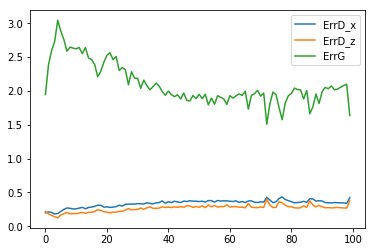

In [13]:
plt.plot(ERRD_x, label='ErrD_x')
plt.plot(ERRD_z, label='ErrD_z')
plt.plot(ERRG, label='ErrG')
plt.legend()
plt.show()

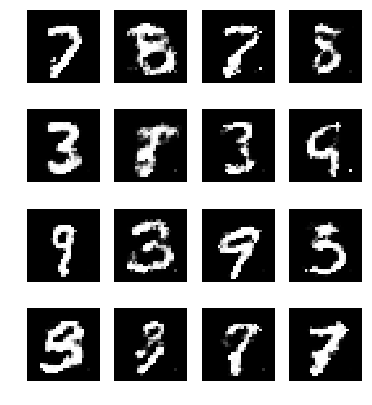

In [18]:
noise.data.normal_(0, 1)
fake = generator(noise)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

### LSGAN

In [19]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential( 
            nn.Linear(config.noise_size, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Sigmoid())
        
    def forward(self, x):
        return self.model(x)
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1), 
            nn.Sigmoid())
    def forward(self, x):
        return self.model(x)

In [20]:
generator = Generator()
discriminator = Discriminator()

In [21]:
optim_G = optim.Adam(params=generator.parameters(), lr=0.0001)
optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001)

criterion = nn.MSELoss()

In [22]:
input = Variable(torch.FloatTensor(config.batch_size, 28*28))
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size))
fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1))
label = Variable(torch.FloatTensor(config.batch_size))
real_label = 1
fake_label = 0

In [25]:
ERRD_x = np.zeros(config.num_epochs)
ERRD_z = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
N = len(dataloader)

for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        ####### 
        # Discriminator stage
        #######
        discriminator.zero_grad()
        
        # real
        label.data.fill_(real_label)
        input.data.copy_(images.resize_(28 * 28))
        output = discriminator(input)
        errD_x = criterion(output[:, 0], label)
        ERRD_x[epoch] += errD_x.item()
        errD_x.backward()
        
        # fake 
        noise.data.normal_(0, 1)
        fake = generator(noise)
        label.data.fill_(fake_label)
        output = discriminator(fake.detach())
        errD_z = criterion(output[:, 0], label)
        ERRD_z[epoch] += errD_z.item()
        errD_z.backward()
        
        optim_D.step()
        
        ####### 
        # Generator stage
        #######
        generator.zero_grad()
        label.data.fill_(real_label)
        output = discriminator(fake)
        errG = criterion(output[:, 0], label)
        ERRG[epoch] += errG.item()
        errG.backward()
        
        optim_G.step()
        
        if (iteration+1) % config.print_freq == 0:
            print('Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(epoch+1,
                                                                                            iteration+1, 
                                                                                            errD_x.item(),
                                                                                            errD_z.item(), 
                                                                                            errG.item()))
ERRD_x /= N
ERRD_z /= N
ERRG /= N

Epoch:1 Iter: 100 errD_x: 0.09 errD_z: 0.03 errG: 0.71
Epoch:1 Iter: 200 errD_x: 0.07 errD_z: 0.01 errG: 0.83
Epoch:1 Iter: 300 errD_x: 0.04 errD_z: 0.01 errG: 0.89
Epoch:1 Iter: 400 errD_x: 0.04 errD_z: 0.10 errG: 0.72
Epoch:1 Iter: 500 errD_x: 0.03 errD_z: 0.13 errG: 0.60
Epoch:1 Iter: 600 errD_x: 0.04 errD_z: 0.08 errG: 0.65
Epoch:1 Iter: 700 errD_x: 0.17 errD_z: 0.06 errG: 0.67
Epoch:1 Iter: 800 errD_x: 0.01 errD_z: 0.03 errG: 0.75
Epoch:1 Iter: 900 errD_x: 0.00 errD_z: 0.02 errG: 0.80
Epoch:1 Iter: 1000 errD_x: 0.01 errD_z: 0.02 errG: 0.78
Epoch:1 Iter: 1100 errD_x: 0.02 errD_z: 0.03 errG: 0.71
Epoch:1 Iter: 1200 errD_x: 0.08 errD_z: 0.02 errG: 0.74
Epoch:1 Iter: 1300 errD_x: 0.01 errD_z: 0.03 errG: 0.73
Epoch:1 Iter: 1400 errD_x: 0.45 errD_z: 0.04 errG: 0.67
Epoch:1 Iter: 1500 errD_x: 0.00 errD_z: 0.04 errG: 0.68
Epoch:1 Iter: 1600 errD_x: 0.00 errD_z: 0.06 errG: 0.61
Epoch:1 Iter: 1700 errD_x: 0.00 errD_z: 0.10 errG: 0.50
Epoch:1 Iter: 1800 errD_x: 0.02 errD_z: 0.15 errG: 0.42
E

Epoch:4 Iter: 3700 errD_x: 0.96 errD_z: 0.01 errG: 0.85
Epoch:5 Iter: 100 errD_x: 0.00 errD_z: 0.00 errG: 0.91
Epoch:5 Iter: 200 errD_x: 0.10 errD_z: 0.07 errG: 0.70
Epoch:5 Iter: 300 errD_x: 0.00 errD_z: 0.02 errG: 0.81
Epoch:5 Iter: 400 errD_x: 0.00 errD_z: 0.03 errG: 0.80
Epoch:5 Iter: 500 errD_x: 0.00 errD_z: 0.06 errG: 0.70
Epoch:5 Iter: 600 errD_x: 0.00 errD_z: 0.12 errG: 0.59
Epoch:5 Iter: 700 errD_x: 0.00 errD_z: 0.04 errG: 0.72
Epoch:5 Iter: 800 errD_x: 0.02 errD_z: 0.06 errG: 0.71
Epoch:5 Iter: 900 errD_x: 0.00 errD_z: 0.05 errG: 0.73
Epoch:5 Iter: 1000 errD_x: 0.07 errD_z: 0.05 errG: 0.72
Epoch:5 Iter: 1100 errD_x: 0.00 errD_z: 0.01 errG: 0.85
Epoch:5 Iter: 1200 errD_x: 0.00 errD_z: 0.08 errG: 0.67
Epoch:5 Iter: 1300 errD_x: 0.30 errD_z: 0.01 errG: 0.84
Epoch:5 Iter: 1400 errD_x: 0.05 errD_z: 0.04 errG: 0.76
Epoch:5 Iter: 1500 errD_x: 0.00 errD_z: 0.05 errG: 0.70
Epoch:5 Iter: 1600 errD_x: 0.00 errD_z: 0.16 errG: 0.53
Epoch:5 Iter: 1700 errD_x: 0.00 errD_z: 0.03 errG: 0.78
E

Epoch:8 Iter: 3600 errD_x: 0.00 errD_z: 0.02 errG: 0.83
Epoch:8 Iter: 3700 errD_x: 0.00 errD_z: 0.03 errG: 0.79
Epoch:9 Iter: 100 errD_x: 0.00 errD_z: 0.06 errG: 0.71
Epoch:9 Iter: 200 errD_x: 0.00 errD_z: 0.10 errG: 0.67
Epoch:9 Iter: 300 errD_x: 0.02 errD_z: 0.07 errG: 0.72
Epoch:9 Iter: 400 errD_x: 0.11 errD_z: 0.11 errG: 0.68
Epoch:9 Iter: 500 errD_x: 0.00 errD_z: 0.02 errG: 0.84
Epoch:9 Iter: 600 errD_x: 0.02 errD_z: 0.01 errG: 0.86
Epoch:9 Iter: 700 errD_x: 0.00 errD_z: 0.04 errG: 0.82
Epoch:9 Iter: 800 errD_x: 0.00 errD_z: 0.03 errG: 0.82
Epoch:9 Iter: 900 errD_x: 0.05 errD_z: 0.06 errG: 0.72
Epoch:9 Iter: 1000 errD_x: 0.00 errD_z: 0.06 errG: 0.72
Epoch:9 Iter: 1100 errD_x: 0.00 errD_z: 0.06 errG: 0.70
Epoch:9 Iter: 1200 errD_x: 0.00 errD_z: 0.01 errG: 0.84
Epoch:9 Iter: 1300 errD_x: 0.03 errD_z: 0.02 errG: 0.78
Epoch:9 Iter: 1400 errD_x: 0.02 errD_z: 0.07 errG: 0.69
Epoch:9 Iter: 1500 errD_x: 0.00 errD_z: 0.03 errG: 0.83
Epoch:9 Iter: 1600 errD_x: 0.00 errD_z: 0.04 errG: 0.80
E

Epoch:12 Iter: 3400 errD_x: 0.00 errD_z: 0.08 errG: 0.74
Epoch:12 Iter: 3500 errD_x: 0.84 errD_z: 0.06 errG: 0.77
Epoch:12 Iter: 3600 errD_x: 0.00 errD_z: 0.02 errG: 0.85
Epoch:12 Iter: 3700 errD_x: 0.03 errD_z: 0.03 errG: 0.77
Epoch:13 Iter: 100 errD_x: 0.01 errD_z: 0.08 errG: 0.75
Epoch:13 Iter: 200 errD_x: 0.00 errD_z: 0.05 errG: 0.76
Epoch:13 Iter: 300 errD_x: 0.00 errD_z: 0.04 errG: 0.77
Epoch:13 Iter: 400 errD_x: 0.00 errD_z: 0.10 errG: 0.73
Epoch:13 Iter: 500 errD_x: 0.00 errD_z: 0.01 errG: 0.83
Epoch:13 Iter: 600 errD_x: 0.00 errD_z: 0.06 errG: 0.70
Epoch:13 Iter: 700 errD_x: 0.00 errD_z: 0.05 errG: 0.69
Epoch:13 Iter: 800 errD_x: 0.00 errD_z: 0.05 errG: 0.71
Epoch:13 Iter: 900 errD_x: 0.47 errD_z: 0.01 errG: 0.88
Epoch:13 Iter: 1000 errD_x: 0.00 errD_z: 0.02 errG: 0.80
Epoch:13 Iter: 1100 errD_x: 0.15 errD_z: 0.01 errG: 0.82
Epoch:13 Iter: 1200 errD_x: 0.43 errD_z: 0.02 errG: 0.82
Epoch:13 Iter: 1300 errD_x: 0.00 errD_z: 0.06 errG: 0.69
Epoch:13 Iter: 1400 errD_x: 0.00 errD_z:

Epoch:16 Iter: 3100 errD_x: 0.00 errD_z: 0.04 errG: 0.78
Epoch:16 Iter: 3200 errD_x: 0.02 errD_z: 0.02 errG: 0.84
Epoch:16 Iter: 3300 errD_x: 0.00 errD_z: 0.08 errG: 0.67
Epoch:16 Iter: 3400 errD_x: 0.62 errD_z: 0.11 errG: 0.71
Epoch:16 Iter: 3500 errD_x: 0.00 errD_z: 0.07 errG: 0.69
Epoch:16 Iter: 3600 errD_x: 0.02 errD_z: 0.15 errG: 0.66
Epoch:16 Iter: 3700 errD_x: 0.01 errD_z: 0.00 errG: 0.90
Epoch:17 Iter: 100 errD_x: 0.00 errD_z: 0.12 errG: 0.66
Epoch:17 Iter: 200 errD_x: 0.01 errD_z: 0.10 errG: 0.64
Epoch:17 Iter: 300 errD_x: 0.53 errD_z: 0.05 errG: 0.76
Epoch:17 Iter: 400 errD_x: 0.00 errD_z: 0.12 errG: 0.64
Epoch:17 Iter: 500 errD_x: 0.00 errD_z: 0.07 errG: 0.73
Epoch:17 Iter: 600 errD_x: 0.00 errD_z: 0.02 errG: 0.80
Epoch:17 Iter: 700 errD_x: 0.02 errD_z: 0.11 errG: 0.62
Epoch:17 Iter: 800 errD_x: 0.00 errD_z: 0.06 errG: 0.74
Epoch:17 Iter: 900 errD_x: 0.04 errD_z: 0.03 errG: 0.79
Epoch:17 Iter: 1000 errD_x: 0.70 errD_z: 0.10 errG: 0.59
Epoch:17 Iter: 1100 errD_x: 0.00 errD_z:

Epoch:20 Iter: 2800 errD_x: 0.37 errD_z: 0.03 errG: 0.81
Epoch:20 Iter: 2900 errD_x: 0.01 errD_z: 0.04 errG: 0.72
Epoch:20 Iter: 3000 errD_x: 0.01 errD_z: 0.06 errG: 0.64
Epoch:20 Iter: 3100 errD_x: 0.00 errD_z: 0.03 errG: 0.84
Epoch:20 Iter: 3200 errD_x: 0.00 errD_z: 0.01 errG: 0.87
Epoch:20 Iter: 3300 errD_x: 0.00 errD_z: 0.02 errG: 0.79
Epoch:20 Iter: 3400 errD_x: 0.00 errD_z: 0.04 errG: 0.78
Epoch:20 Iter: 3500 errD_x: 0.00 errD_z: 0.00 errG: 0.92
Epoch:20 Iter: 3600 errD_x: 0.89 errD_z: 0.18 errG: 0.61
Epoch:20 Iter: 3700 errD_x: 0.00 errD_z: 0.05 errG: 0.75
Epoch:21 Iter: 100 errD_x: 0.66 errD_z: 0.10 errG: 0.73
Epoch:21 Iter: 200 errD_x: 0.00 errD_z: 0.05 errG: 0.75
Epoch:21 Iter: 300 errD_x: 0.20 errD_z: 0.06 errG: 0.78
Epoch:21 Iter: 400 errD_x: 0.00 errD_z: 0.05 errG: 0.74
Epoch:21 Iter: 500 errD_x: 0.00 errD_z: 0.03 errG: 0.77
Epoch:21 Iter: 600 errD_x: 0.00 errD_z: 0.04 errG: 0.76
Epoch:21 Iter: 700 errD_x: 0.00 errD_z: 0.06 errG: 0.69
Epoch:21 Iter: 800 errD_x: 0.02 errD_z

Epoch:24 Iter: 2500 errD_x: 0.00 errD_z: 0.07 errG: 0.75
Epoch:24 Iter: 2600 errD_x: 0.00 errD_z: 0.01 errG: 0.85
Epoch:24 Iter: 2700 errD_x: 0.00 errD_z: 0.06 errG: 0.75
Epoch:24 Iter: 2800 errD_x: 0.03 errD_z: 0.10 errG: 0.66
Epoch:24 Iter: 2900 errD_x: 0.84 errD_z: 0.13 errG: 0.61
Epoch:24 Iter: 3000 errD_x: 0.00 errD_z: 0.05 errG: 0.72
Epoch:24 Iter: 3100 errD_x: 0.00 errD_z: 0.14 errG: 0.56
Epoch:24 Iter: 3200 errD_x: 0.00 errD_z: 0.03 errG: 0.81
Epoch:24 Iter: 3300 errD_x: 0.00 errD_z: 0.01 errG: 0.84
Epoch:24 Iter: 3400 errD_x: 0.00 errD_z: 0.08 errG: 0.71
Epoch:24 Iter: 3500 errD_x: 0.00 errD_z: 0.06 errG: 0.74
Epoch:24 Iter: 3600 errD_x: 0.51 errD_z: 0.08 errG: 0.72
Epoch:24 Iter: 3700 errD_x: 0.00 errD_z: 0.07 errG: 0.66
Epoch:25 Iter: 100 errD_x: 0.01 errD_z: 0.05 errG: 0.80
Epoch:25 Iter: 200 errD_x: 0.00 errD_z: 0.04 errG: 0.72
Epoch:25 Iter: 300 errD_x: 0.00 errD_z: 0.07 errG: 0.71
Epoch:25 Iter: 400 errD_x: 0.51 errD_z: 0.04 errG: 0.71
Epoch:25 Iter: 500 errD_x: 0.06 err

Epoch:28 Iter: 2200 errD_x: 0.00 errD_z: 0.08 errG: 0.67
Epoch:28 Iter: 2300 errD_x: 0.00 errD_z: 0.13 errG: 0.62
Epoch:28 Iter: 2400 errD_x: 0.00 errD_z: 0.04 errG: 0.74
Epoch:28 Iter: 2500 errD_x: 0.00 errD_z: 0.04 errG: 0.72
Epoch:28 Iter: 2600 errD_x: 0.01 errD_z: 0.07 errG: 0.71
Epoch:28 Iter: 2700 errD_x: 0.15 errD_z: 0.06 errG: 0.66
Epoch:28 Iter: 2800 errD_x: 0.39 errD_z: 0.03 errG: 0.79
Epoch:28 Iter: 2900 errD_x: 0.00 errD_z: 0.16 errG: 0.55
Epoch:28 Iter: 3000 errD_x: 0.00 errD_z: 0.06 errG: 0.72
Epoch:28 Iter: 3100 errD_x: 0.00 errD_z: 0.04 errG: 0.74
Epoch:28 Iter: 3200 errD_x: 0.00 errD_z: 0.08 errG: 0.70
Epoch:28 Iter: 3300 errD_x: 0.33 errD_z: 0.04 errG: 0.72
Epoch:28 Iter: 3400 errD_x: 0.14 errD_z: 0.08 errG: 0.75
Epoch:28 Iter: 3500 errD_x: 0.00 errD_z: 0.07 errG: 0.70
Epoch:28 Iter: 3600 errD_x: 0.00 errD_z: 0.09 errG: 0.64
Epoch:28 Iter: 3700 errD_x: 0.00 errD_z: 0.11 errG: 0.66
Epoch:29 Iter: 100 errD_x: 0.00 errD_z: 0.10 errG: 0.58
Epoch:29 Iter: 200 errD_x: 0.46 

Epoch:32 Iter: 1900 errD_x: 0.01 errD_z: 0.10 errG: 0.66
Epoch:32 Iter: 2000 errD_x: 0.00 errD_z: 0.02 errG: 0.81
Epoch:32 Iter: 2100 errD_x: 0.00 errD_z: 0.05 errG: 0.71
Epoch:32 Iter: 2200 errD_x: 0.00 errD_z: 0.12 errG: 0.56
Epoch:32 Iter: 2300 errD_x: 0.38 errD_z: 0.05 errG: 0.73
Epoch:32 Iter: 2400 errD_x: 0.00 errD_z: 0.07 errG: 0.66
Epoch:32 Iter: 2500 errD_x: 0.00 errD_z: 0.07 errG: 0.71
Epoch:32 Iter: 2600 errD_x: 0.22 errD_z: 0.10 errG: 0.63
Epoch:32 Iter: 2700 errD_x: 0.23 errD_z: 0.04 errG: 0.74
Epoch:32 Iter: 2800 errD_x: 0.00 errD_z: 0.10 errG: 0.69
Epoch:32 Iter: 2900 errD_x: 0.00 errD_z: 0.05 errG: 0.74
Epoch:32 Iter: 3000 errD_x: 0.16 errD_z: 0.12 errG: 0.61
Epoch:32 Iter: 3100 errD_x: 0.00 errD_z: 0.07 errG: 0.73
Epoch:32 Iter: 3200 errD_x: 0.00 errD_z: 0.02 errG: 0.78
Epoch:32 Iter: 3300 errD_x: 0.00 errD_z: 0.03 errG: 0.74
Epoch:32 Iter: 3400 errD_x: 0.05 errD_z: 0.09 errG: 0.64
Epoch:32 Iter: 3500 errD_x: 0.00 errD_z: 0.14 errG: 0.64
Epoch:32 Iter: 3600 errD_x: 0.8

Epoch:36 Iter: 1600 errD_x: 0.00 errD_z: 0.10 errG: 0.69
Epoch:36 Iter: 1700 errD_x: 0.00 errD_z: 0.06 errG: 0.73
Epoch:36 Iter: 1800 errD_x: 0.01 errD_z: 0.10 errG: 0.63
Epoch:36 Iter: 1900 errD_x: 0.04 errD_z: 0.11 errG: 0.66
Epoch:36 Iter: 2000 errD_x: 0.00 errD_z: 0.05 errG: 0.70
Epoch:36 Iter: 2100 errD_x: 0.50 errD_z: 0.10 errG: 0.61
Epoch:36 Iter: 2200 errD_x: 0.58 errD_z: 0.08 errG: 0.72
Epoch:36 Iter: 2300 errD_x: 0.00 errD_z: 0.05 errG: 0.69
Epoch:36 Iter: 2400 errD_x: 0.01 errD_z: 0.18 errG: 0.56
Epoch:36 Iter: 2500 errD_x: 0.00 errD_z: 0.09 errG: 0.64
Epoch:36 Iter: 2600 errD_x: 0.00 errD_z: 0.05 errG: 0.66
Epoch:36 Iter: 2700 errD_x: 0.11 errD_z: 0.07 errG: 0.67
Epoch:36 Iter: 2800 errD_x: 0.01 errD_z: 0.14 errG: 0.55
Epoch:36 Iter: 2900 errD_x: 0.01 errD_z: 0.10 errG: 0.64
Epoch:36 Iter: 3000 errD_x: 0.00 errD_z: 0.11 errG: 0.59
Epoch:36 Iter: 3100 errD_x: 0.10 errD_z: 0.12 errG: 0.57
Epoch:36 Iter: 3200 errD_x: 0.03 errD_z: 0.02 errG: 0.79
Epoch:36 Iter: 3300 errD_x: 0.1

Epoch:40 Iter: 1300 errD_x: 0.00 errD_z: 0.03 errG: 0.77
Epoch:40 Iter: 1400 errD_x: 0.31 errD_z: 0.03 errG: 0.72
Epoch:40 Iter: 1500 errD_x: 0.00 errD_z: 0.04 errG: 0.71
Epoch:40 Iter: 1600 errD_x: 0.00 errD_z: 0.04 errG: 0.72
Epoch:40 Iter: 1700 errD_x: 0.00 errD_z: 0.08 errG: 0.62
Epoch:40 Iter: 1800 errD_x: 0.00 errD_z: 0.11 errG: 0.64
Epoch:40 Iter: 1900 errD_x: 0.00 errD_z: 0.11 errG: 0.64
Epoch:40 Iter: 2000 errD_x: 0.00 errD_z: 0.10 errG: 0.64
Epoch:40 Iter: 2100 errD_x: 0.01 errD_z: 0.06 errG: 0.68
Epoch:40 Iter: 2200 errD_x: 0.66 errD_z: 0.13 errG: 0.56
Epoch:40 Iter: 2300 errD_x: 0.00 errD_z: 0.05 errG: 0.70
Epoch:40 Iter: 2400 errD_x: 0.20 errD_z: 0.07 errG: 0.71
Epoch:40 Iter: 2500 errD_x: 0.30 errD_z: 0.03 errG: 0.75
Epoch:40 Iter: 2600 errD_x: 0.38 errD_z: 0.08 errG: 0.68
Epoch:40 Iter: 2700 errD_x: 0.00 errD_z: 0.05 errG: 0.73
Epoch:40 Iter: 2800 errD_x: 0.00 errD_z: 0.08 errG: 0.66
Epoch:40 Iter: 2900 errD_x: 0.00 errD_z: 0.04 errG: 0.74
Epoch:40 Iter: 3000 errD_x: 0.0

Epoch:44 Iter: 1000 errD_x: 0.00 errD_z: 0.03 errG: 0.73
Epoch:44 Iter: 1100 errD_x: 0.96 errD_z: 0.05 errG: 0.70
Epoch:44 Iter: 1200 errD_x: 0.00 errD_z: 0.03 errG: 0.73
Epoch:44 Iter: 1300 errD_x: 0.05 errD_z: 0.03 errG: 0.77
Epoch:44 Iter: 1400 errD_x: 0.01 errD_z: 0.07 errG: 0.71
Epoch:44 Iter: 1500 errD_x: 0.42 errD_z: 0.08 errG: 0.67
Epoch:44 Iter: 1600 errD_x: 0.14 errD_z: 0.09 errG: 0.65
Epoch:44 Iter: 1700 errD_x: 0.00 errD_z: 0.04 errG: 0.73
Epoch:44 Iter: 1800 errD_x: 0.00 errD_z: 0.03 errG: 0.75
Epoch:44 Iter: 1900 errD_x: 0.00 errD_z: 0.10 errG: 0.65
Epoch:44 Iter: 2000 errD_x: 0.05 errD_z: 0.12 errG: 0.60
Epoch:44 Iter: 2100 errD_x: 0.04 errD_z: 0.08 errG: 0.64
Epoch:44 Iter: 2200 errD_x: 0.00 errD_z: 0.09 errG: 0.63
Epoch:44 Iter: 2300 errD_x: 0.13 errD_z: 0.03 errG: 0.77
Epoch:44 Iter: 2400 errD_x: 0.16 errD_z: 0.07 errG: 0.67
Epoch:44 Iter: 2500 errD_x: 0.00 errD_z: 0.09 errG: 0.66
Epoch:44 Iter: 2600 errD_x: 0.56 errD_z: 0.12 errG: 0.61
Epoch:44 Iter: 2700 errD_x: 0.0

Epoch:48 Iter: 700 errD_x: 0.00 errD_z: 0.09 errG: 0.65
Epoch:48 Iter: 800 errD_x: 0.01 errD_z: 0.18 errG: 0.51
Epoch:48 Iter: 900 errD_x: 0.00 errD_z: 0.07 errG: 0.68
Epoch:48 Iter: 1000 errD_x: 0.22 errD_z: 0.11 errG: 0.60
Epoch:48 Iter: 1100 errD_x: 0.25 errD_z: 0.08 errG: 0.69
Epoch:48 Iter: 1200 errD_x: 0.04 errD_z: 0.03 errG: 0.77
Epoch:48 Iter: 1300 errD_x: 0.00 errD_z: 0.14 errG: 0.55
Epoch:48 Iter: 1400 errD_x: 0.00 errD_z: 0.08 errG: 0.64
Epoch:48 Iter: 1500 errD_x: 0.79 errD_z: 0.12 errG: 0.61
Epoch:48 Iter: 1600 errD_x: 0.88 errD_z: 0.09 errG: 0.61
Epoch:48 Iter: 1700 errD_x: 0.00 errD_z: 0.11 errG: 0.62
Epoch:48 Iter: 1800 errD_x: 0.07 errD_z: 0.05 errG: 0.70
Epoch:48 Iter: 1900 errD_x: 0.00 errD_z: 0.12 errG: 0.58
Epoch:48 Iter: 2000 errD_x: 0.04 errD_z: 0.04 errG: 0.70
Epoch:48 Iter: 2100 errD_x: 0.00 errD_z: 0.10 errG: 0.63
Epoch:48 Iter: 2200 errD_x: 0.58 errD_z: 0.15 errG: 0.55
Epoch:48 Iter: 2300 errD_x: 0.00 errD_z: 0.14 errG: 0.60
Epoch:48 Iter: 2400 errD_x: 0.01 e

Epoch:52 Iter: 400 errD_x: 0.36 errD_z: 0.08 errG: 0.63
Epoch:52 Iter: 500 errD_x: 0.08 errD_z: 0.06 errG: 0.77
Epoch:52 Iter: 600 errD_x: 0.00 errD_z: 0.11 errG: 0.68
Epoch:52 Iter: 700 errD_x: 0.00 errD_z: 0.04 errG: 0.73
Epoch:52 Iter: 800 errD_x: 0.03 errD_z: 0.19 errG: 0.53
Epoch:52 Iter: 900 errD_x: 0.00 errD_z: 0.07 errG: 0.70
Epoch:52 Iter: 1000 errD_x: 0.00 errD_z: 0.04 errG: 0.70
Epoch:52 Iter: 1100 errD_x: 0.00 errD_z: 0.09 errG: 0.60
Epoch:52 Iter: 1200 errD_x: 0.19 errD_z: 0.10 errG: 0.72
Epoch:52 Iter: 1300 errD_x: 0.00 errD_z: 0.07 errG: 0.64
Epoch:52 Iter: 1400 errD_x: 0.00 errD_z: 0.13 errG: 0.53
Epoch:52 Iter: 1500 errD_x: 0.00 errD_z: 0.06 errG: 0.67
Epoch:52 Iter: 1600 errD_x: 0.00 errD_z: 0.07 errG: 0.63
Epoch:52 Iter: 1700 errD_x: 0.00 errD_z: 0.09 errG: 0.61
Epoch:52 Iter: 1800 errD_x: 0.37 errD_z: 0.07 errG: 0.69
Epoch:52 Iter: 1900 errD_x: 0.00 errD_z: 0.03 errG: 0.72
Epoch:52 Iter: 2000 errD_x: 0.02 errD_z: 0.05 errG: 0.70
Epoch:52 Iter: 2100 errD_x: 0.00 errD

Epoch:56 Iter: 100 errD_x: 0.01 errD_z: 0.13 errG: 0.60
Epoch:56 Iter: 200 errD_x: 0.09 errD_z: 0.12 errG: 0.63
Epoch:56 Iter: 300 errD_x: 0.00 errD_z: 0.10 errG: 0.67
Epoch:56 Iter: 400 errD_x: 0.00 errD_z: 0.03 errG: 0.74
Epoch:56 Iter: 500 errD_x: 0.63 errD_z: 0.02 errG: 0.81
Epoch:56 Iter: 600 errD_x: 0.01 errD_z: 0.06 errG: 0.73
Epoch:56 Iter: 700 errD_x: 0.03 errD_z: 0.15 errG: 0.59
Epoch:56 Iter: 800 errD_x: 0.00 errD_z: 0.05 errG: 0.72
Epoch:56 Iter: 900 errD_x: 0.33 errD_z: 0.04 errG: 0.71
Epoch:56 Iter: 1000 errD_x: 0.30 errD_z: 0.10 errG: 0.65
Epoch:56 Iter: 1100 errD_x: 0.06 errD_z: 0.09 errG: 0.61
Epoch:56 Iter: 1200 errD_x: 0.00 errD_z: 0.05 errG: 0.70
Epoch:56 Iter: 1300 errD_x: 0.00 errD_z: 0.08 errG: 0.61
Epoch:56 Iter: 1400 errD_x: 0.00 errD_z: 0.04 errG: 0.73
Epoch:56 Iter: 1500 errD_x: 0.00 errD_z: 0.06 errG: 0.69
Epoch:56 Iter: 1600 errD_x: 0.00 errD_z: 0.11 errG: 0.62
Epoch:56 Iter: 1700 errD_x: 0.38 errD_z: 0.11 errG: 0.63
Epoch:56 Iter: 1800 errD_x: 0.00 errD_z:

Epoch:59 Iter: 3500 errD_x: 0.00 errD_z: 0.08 errG: 0.62
Epoch:59 Iter: 3600 errD_x: 0.00 errD_z: 0.13 errG: 0.58
Epoch:59 Iter: 3700 errD_x: 0.00 errD_z: 0.05 errG: 0.69
Epoch:60 Iter: 100 errD_x: 0.00 errD_z: 0.10 errG: 0.55
Epoch:60 Iter: 200 errD_x: 0.00 errD_z: 0.03 errG: 0.72
Epoch:60 Iter: 300 errD_x: 0.02 errD_z: 0.10 errG: 0.66
Epoch:60 Iter: 400 errD_x: 0.00 errD_z: 0.03 errG: 0.77
Epoch:60 Iter: 500 errD_x: 0.07 errD_z: 0.08 errG: 0.71
Epoch:60 Iter: 600 errD_x: 0.00 errD_z: 0.17 errG: 0.53
Epoch:60 Iter: 700 errD_x: 0.60 errD_z: 0.08 errG: 0.59
Epoch:60 Iter: 800 errD_x: 0.00 errD_z: 0.11 errG: 0.59
Epoch:60 Iter: 900 errD_x: 0.01 errD_z: 0.09 errG: 0.60
Epoch:60 Iter: 1000 errD_x: 0.64 errD_z: 0.05 errG: 0.70
Epoch:60 Iter: 1100 errD_x: 0.00 errD_z: 0.07 errG: 0.67
Epoch:60 Iter: 1200 errD_x: 0.00 errD_z: 0.05 errG: 0.72
Epoch:60 Iter: 1300 errD_x: 0.00 errD_z: 0.05 errG: 0.68
Epoch:60 Iter: 1400 errD_x: 0.00 errD_z: 0.14 errG: 0.53
Epoch:60 Iter: 1500 errD_x: 0.00 errD_z:

Epoch:63 Iter: 3200 errD_x: 0.01 errD_z: 0.15 errG: 0.57
Epoch:63 Iter: 3300 errD_x: 0.10 errD_z: 0.13 errG: 0.60
Epoch:63 Iter: 3400 errD_x: 0.40 errD_z: 0.04 errG: 0.70
Epoch:63 Iter: 3500 errD_x: 0.00 errD_z: 0.03 errG: 0.72
Epoch:63 Iter: 3600 errD_x: 0.07 errD_z: 0.09 errG: 0.61
Epoch:63 Iter: 3700 errD_x: 0.61 errD_z: 0.18 errG: 0.50
Epoch:64 Iter: 100 errD_x: 0.00 errD_z: 0.04 errG: 0.70
Epoch:64 Iter: 200 errD_x: 0.05 errD_z: 0.15 errG: 0.52
Epoch:64 Iter: 300 errD_x: 0.00 errD_z: 0.04 errG: 0.72
Epoch:64 Iter: 400 errD_x: 0.00 errD_z: 0.02 errG: 0.75
Epoch:64 Iter: 500 errD_x: 0.00 errD_z: 0.06 errG: 0.69
Epoch:64 Iter: 600 errD_x: 0.00 errD_z: 0.12 errG: 0.57
Epoch:64 Iter: 700 errD_x: 0.06 errD_z: 0.05 errG: 0.71
Epoch:64 Iter: 800 errD_x: 0.81 errD_z: 0.06 errG: 0.67
Epoch:64 Iter: 900 errD_x: 0.07 errD_z: 0.09 errG: 0.61
Epoch:64 Iter: 1000 errD_x: 0.02 errD_z: 0.05 errG: 0.68
Epoch:64 Iter: 1100 errD_x: 0.00 errD_z: 0.04 errG: 0.72
Epoch:64 Iter: 1200 errD_x: 0.00 errD_z:

Epoch:67 Iter: 2900 errD_x: 0.02 errD_z: 0.06 errG: 0.71
Epoch:67 Iter: 3000 errD_x: 0.00 errD_z: 0.11 errG: 0.63
Epoch:67 Iter: 3100 errD_x: 0.18 errD_z: 0.11 errG: 0.59
Epoch:67 Iter: 3200 errD_x: 0.00 errD_z: 0.14 errG: 0.60
Epoch:67 Iter: 3300 errD_x: 0.01 errD_z: 0.07 errG: 0.66
Epoch:67 Iter: 3400 errD_x: 0.00 errD_z: 0.07 errG: 0.65
Epoch:67 Iter: 3500 errD_x: 0.03 errD_z: 0.08 errG: 0.65
Epoch:67 Iter: 3600 errD_x: 0.00 errD_z: 0.06 errG: 0.67
Epoch:67 Iter: 3700 errD_x: 0.00 errD_z: 0.03 errG: 0.75
Epoch:68 Iter: 100 errD_x: 0.00 errD_z: 0.05 errG: 0.66
Epoch:68 Iter: 200 errD_x: 0.00 errD_z: 0.12 errG: 0.62
Epoch:68 Iter: 300 errD_x: 0.00 errD_z: 0.09 errG: 0.58
Epoch:68 Iter: 400 errD_x: 0.00 errD_z: 0.04 errG: 0.69
Epoch:68 Iter: 500 errD_x: 0.01 errD_z: 0.18 errG: 0.46
Epoch:68 Iter: 600 errD_x: 0.00 errD_z: 0.17 errG: 0.57
Epoch:68 Iter: 700 errD_x: 0.75 errD_z: 0.11 errG: 0.64
Epoch:68 Iter: 800 errD_x: 0.00 errD_z: 0.15 errG: 0.59
Epoch:68 Iter: 900 errD_x: 0.58 errD_z:

Epoch:71 Iter: 2600 errD_x: 0.00 errD_z: 0.13 errG: 0.51
Epoch:71 Iter: 2700 errD_x: 0.00 errD_z: 0.05 errG: 0.74
Epoch:71 Iter: 2800 errD_x: 0.03 errD_z: 0.02 errG: 0.80
Epoch:71 Iter: 2900 errD_x: 0.00 errD_z: 0.07 errG: 0.76
Epoch:71 Iter: 3000 errD_x: 0.00 errD_z: 0.09 errG: 0.65
Epoch:71 Iter: 3100 errD_x: 0.00 errD_z: 0.04 errG: 0.74
Epoch:71 Iter: 3200 errD_x: 0.03 errD_z: 0.07 errG: 0.64
Epoch:71 Iter: 3300 errD_x: 0.00 errD_z: 0.10 errG: 0.58
Epoch:71 Iter: 3400 errD_x: 0.08 errD_z: 0.15 errG: 0.54
Epoch:71 Iter: 3500 errD_x: 0.04 errD_z: 0.08 errG: 0.59
Epoch:71 Iter: 3600 errD_x: 0.21 errD_z: 0.10 errG: 0.63
Epoch:71 Iter: 3700 errD_x: 0.00 errD_z: 0.16 errG: 0.58
Epoch:72 Iter: 100 errD_x: 0.00 errD_z: 0.07 errG: 0.61
Epoch:72 Iter: 200 errD_x: 0.05 errD_z: 0.13 errG: 0.58
Epoch:72 Iter: 300 errD_x: 0.00 errD_z: 0.09 errG: 0.54
Epoch:72 Iter: 400 errD_x: 0.00 errD_z: 0.05 errG: 0.70
Epoch:72 Iter: 500 errD_x: 0.59 errD_z: 0.15 errG: 0.58
Epoch:72 Iter: 600 errD_x: 0.00 errD

Epoch:75 Iter: 2300 errD_x: 0.00 errD_z: 0.03 errG: 0.78
Epoch:75 Iter: 2400 errD_x: 0.00 errD_z: 0.06 errG: 0.67
Epoch:75 Iter: 2500 errD_x: 0.01 errD_z: 0.09 errG: 0.66
Epoch:75 Iter: 2600 errD_x: 0.13 errD_z: 0.03 errG: 0.70
Epoch:75 Iter: 2700 errD_x: 0.00 errD_z: 0.08 errG: 0.69
Epoch:75 Iter: 2800 errD_x: 0.00 errD_z: 0.14 errG: 0.52
Epoch:75 Iter: 2900 errD_x: 0.00 errD_z: 0.25 errG: 0.39
Epoch:75 Iter: 3000 errD_x: 0.00 errD_z: 0.08 errG: 0.64
Epoch:75 Iter: 3100 errD_x: 0.04 errD_z: 0.15 errG: 0.57
Epoch:75 Iter: 3200 errD_x: 0.13 errD_z: 0.17 errG: 0.52
Epoch:75 Iter: 3300 errD_x: 0.17 errD_z: 0.16 errG: 0.46
Epoch:75 Iter: 3400 errD_x: 0.66 errD_z: 0.07 errG: 0.66
Epoch:75 Iter: 3500 errD_x: 0.00 errD_z: 0.13 errG: 0.57
Epoch:75 Iter: 3600 errD_x: 0.00 errD_z: 0.09 errG: 0.63
Epoch:75 Iter: 3700 errD_x: 0.28 errD_z: 0.18 errG: 0.48
Epoch:76 Iter: 100 errD_x: 0.33 errD_z: 0.08 errG: 0.69
Epoch:76 Iter: 200 errD_x: 0.00 errD_z: 0.11 errG: 0.60
Epoch:76 Iter: 300 errD_x: 0.00 e

Epoch:79 Iter: 2000 errD_x: 0.00 errD_z: 0.17 errG: 0.56
Epoch:79 Iter: 2100 errD_x: 0.06 errD_z: 0.09 errG: 0.64
Epoch:79 Iter: 2200 errD_x: 0.00 errD_z: 0.03 errG: 0.75
Epoch:79 Iter: 2300 errD_x: 0.05 errD_z: 0.05 errG: 0.66
Epoch:79 Iter: 2400 errD_x: 0.00 errD_z: 0.11 errG: 0.58
Epoch:79 Iter: 2500 errD_x: 0.00 errD_z: 0.01 errG: 0.82
Epoch:79 Iter: 2600 errD_x: 0.00 errD_z: 0.08 errG: 0.68
Epoch:79 Iter: 2700 errD_x: 0.36 errD_z: 0.22 errG: 0.47
Epoch:79 Iter: 2800 errD_x: 0.53 errD_z: 0.11 errG: 0.60
Epoch:79 Iter: 2900 errD_x: 0.53 errD_z: 0.08 errG: 0.66
Epoch:79 Iter: 3000 errD_x: 0.00 errD_z: 0.11 errG: 0.63
Epoch:79 Iter: 3100 errD_x: 0.00 errD_z: 0.11 errG: 0.60
Epoch:79 Iter: 3200 errD_x: 0.92 errD_z: 0.08 errG: 0.66
Epoch:79 Iter: 3300 errD_x: 0.01 errD_z: 0.07 errG: 0.63
Epoch:79 Iter: 3400 errD_x: 0.00 errD_z: 0.07 errG: 0.64
Epoch:79 Iter: 3500 errD_x: 0.00 errD_z: 0.06 errG: 0.69
Epoch:79 Iter: 3600 errD_x: 0.00 errD_z: 0.11 errG: 0.64
Epoch:79 Iter: 3700 errD_x: 0.0

Epoch:83 Iter: 1700 errD_x: 0.57 errD_z: 0.07 errG: 0.68
Epoch:83 Iter: 1800 errD_x: 0.72 errD_z: 0.05 errG: 0.69
Epoch:83 Iter: 1900 errD_x: 0.23 errD_z: 0.09 errG: 0.64
Epoch:83 Iter: 2000 errD_x: 0.00 errD_z: 0.06 errG: 0.72
Epoch:83 Iter: 2100 errD_x: 0.01 errD_z: 0.07 errG: 0.66
Epoch:83 Iter: 2200 errD_x: 0.03 errD_z: 0.10 errG: 0.64
Epoch:83 Iter: 2300 errD_x: 0.00 errD_z: 0.09 errG: 0.63
Epoch:83 Iter: 2400 errD_x: 0.04 errD_z: 0.12 errG: 0.60
Epoch:83 Iter: 2500 errD_x: 0.00 errD_z: 0.08 errG: 0.66
Epoch:83 Iter: 2600 errD_x: 0.00 errD_z: 0.07 errG: 0.71
Epoch:83 Iter: 2700 errD_x: 0.22 errD_z: 0.11 errG: 0.62
Epoch:83 Iter: 2800 errD_x: 0.00 errD_z: 0.17 errG: 0.53
Epoch:83 Iter: 2900 errD_x: 0.24 errD_z: 0.06 errG: 0.67
Epoch:83 Iter: 3000 errD_x: 0.81 errD_z: 0.07 errG: 0.65
Epoch:83 Iter: 3100 errD_x: 0.00 errD_z: 0.06 errG: 0.67
Epoch:83 Iter: 3200 errD_x: 0.37 errD_z: 0.09 errG: 0.63
Epoch:83 Iter: 3300 errD_x: 0.00 errD_z: 0.11 errG: 0.61
Epoch:83 Iter: 3400 errD_x: 0.0

Epoch:87 Iter: 1400 errD_x: 0.00 errD_z: 0.10 errG: 0.61
Epoch:87 Iter: 1500 errD_x: 0.10 errD_z: 0.14 errG: 0.58
Epoch:87 Iter: 1600 errD_x: 0.00 errD_z: 0.16 errG: 0.51
Epoch:87 Iter: 1700 errD_x: 0.69 errD_z: 0.07 errG: 0.62
Epoch:87 Iter: 1800 errD_x: 0.73 errD_z: 0.08 errG: 0.69
Epoch:87 Iter: 1900 errD_x: 0.09 errD_z: 0.06 errG: 0.68
Epoch:87 Iter: 2000 errD_x: 0.02 errD_z: 0.03 errG: 0.77
Epoch:87 Iter: 2100 errD_x: 0.00 errD_z: 0.08 errG: 0.77
Epoch:87 Iter: 2200 errD_x: 0.00 errD_z: 0.10 errG: 0.65
Epoch:87 Iter: 2300 errD_x: 0.00 errD_z: 0.09 errG: 0.64
Epoch:87 Iter: 2400 errD_x: 0.04 errD_z: 0.08 errG: 0.65
Epoch:87 Iter: 2500 errD_x: 0.00 errD_z: 0.11 errG: 0.63
Epoch:87 Iter: 2600 errD_x: 0.00 errD_z: 0.11 errG: 0.59
Epoch:87 Iter: 2700 errD_x: 0.00 errD_z: 0.06 errG: 0.71
Epoch:87 Iter: 2800 errD_x: 0.66 errD_z: 0.10 errG: 0.64
Epoch:87 Iter: 2900 errD_x: 0.00 errD_z: 0.10 errG: 0.58
Epoch:87 Iter: 3000 errD_x: 0.03 errD_z: 0.19 errG: 0.58
Epoch:87 Iter: 3100 errD_x: 0.0

Epoch:91 Iter: 1100 errD_x: 0.03 errD_z: 0.04 errG: 0.70
Epoch:91 Iter: 1200 errD_x: 0.00 errD_z: 0.11 errG: 0.63
Epoch:91 Iter: 1300 errD_x: 0.00 errD_z: 0.12 errG: 0.60
Epoch:91 Iter: 1400 errD_x: 0.00 errD_z: 0.06 errG: 0.66
Epoch:91 Iter: 1500 errD_x: 0.07 errD_z: 0.05 errG: 0.73
Epoch:91 Iter: 1600 errD_x: 0.17 errD_z: 0.08 errG: 0.72
Epoch:91 Iter: 1700 errD_x: 0.00 errD_z: 0.04 errG: 0.74
Epoch:91 Iter: 1800 errD_x: 0.00 errD_z: 0.15 errG: 0.57
Epoch:91 Iter: 1900 errD_x: 0.00 errD_z: 0.14 errG: 0.53
Epoch:91 Iter: 2000 errD_x: 0.75 errD_z: 0.13 errG: 0.63
Epoch:91 Iter: 2100 errD_x: 0.47 errD_z: 0.09 errG: 0.68
Epoch:91 Iter: 2200 errD_x: 0.00 errD_z: 0.09 errG: 0.69
Epoch:91 Iter: 2300 errD_x: 0.41 errD_z: 0.03 errG: 0.77
Epoch:91 Iter: 2400 errD_x: 0.61 errD_z: 0.08 errG: 0.58
Epoch:91 Iter: 2500 errD_x: 0.03 errD_z: 0.05 errG: 0.72
Epoch:91 Iter: 2600 errD_x: 0.00 errD_z: 0.17 errG: 0.50
Epoch:91 Iter: 2700 errD_x: 0.44 errD_z: 0.10 errG: 0.65
Epoch:91 Iter: 2800 errD_x: 0.0

Epoch:95 Iter: 800 errD_x: 0.00 errD_z: 0.09 errG: 0.61
Epoch:95 Iter: 900 errD_x: 0.00 errD_z: 0.03 errG: 0.79
Epoch:95 Iter: 1000 errD_x: 0.00 errD_z: 0.07 errG: 0.64
Epoch:95 Iter: 1100 errD_x: 0.03 errD_z: 0.04 errG: 0.74
Epoch:95 Iter: 1200 errD_x: 0.00 errD_z: 0.11 errG: 0.57
Epoch:95 Iter: 1300 errD_x: 0.01 errD_z: 0.09 errG: 0.60
Epoch:95 Iter: 1400 errD_x: 0.84 errD_z: 0.10 errG: 0.59
Epoch:95 Iter: 1500 errD_x: 0.00 errD_z: 0.14 errG: 0.51
Epoch:95 Iter: 1600 errD_x: 0.01 errD_z: 0.08 errG: 0.60
Epoch:95 Iter: 1700 errD_x: 0.00 errD_z: 0.08 errG: 0.61
Epoch:95 Iter: 1800 errD_x: 0.01 errD_z: 0.08 errG: 0.70
Epoch:95 Iter: 1900 errD_x: 0.00 errD_z: 0.14 errG: 0.58
Epoch:95 Iter: 2000 errD_x: 0.88 errD_z: 0.05 errG: 0.68
Epoch:95 Iter: 2100 errD_x: 0.70 errD_z: 0.05 errG: 0.71
Epoch:95 Iter: 2200 errD_x: 0.11 errD_z: 0.11 errG: 0.65
Epoch:95 Iter: 2300 errD_x: 0.06 errD_z: 0.08 errG: 0.69
Epoch:95 Iter: 2400 errD_x: 0.00 errD_z: 0.05 errG: 0.74
Epoch:95 Iter: 2500 errD_x: 0.00 

Epoch:99 Iter: 500 errD_x: 0.02 errD_z: 0.02 errG: 0.77
Epoch:99 Iter: 600 errD_x: 0.01 errD_z: 0.11 errG: 0.61
Epoch:99 Iter: 700 errD_x: 0.77 errD_z: 0.10 errG: 0.65
Epoch:99 Iter: 800 errD_x: 0.00 errD_z: 0.04 errG: 0.74
Epoch:99 Iter: 900 errD_x: 0.14 errD_z: 0.07 errG: 0.66
Epoch:99 Iter: 1000 errD_x: 0.00 errD_z: 0.10 errG: 0.57
Epoch:99 Iter: 1100 errD_x: 0.08 errD_z: 0.09 errG: 0.67
Epoch:99 Iter: 1200 errD_x: 0.04 errD_z: 0.04 errG: 0.71
Epoch:99 Iter: 1300 errD_x: 0.01 errD_z: 0.09 errG: 0.66
Epoch:99 Iter: 1400 errD_x: 0.00 errD_z: 0.14 errG: 0.62
Epoch:99 Iter: 1500 errD_x: 0.01 errD_z: 0.07 errG: 0.66
Epoch:99 Iter: 1600 errD_x: 0.00 errD_z: 0.09 errG: 0.62
Epoch:99 Iter: 1700 errD_x: 0.01 errD_z: 0.06 errG: 0.76
Epoch:99 Iter: 1800 errD_x: 0.11 errD_z: 0.14 errG: 0.60
Epoch:99 Iter: 1900 errD_x: 0.00 errD_z: 0.07 errG: 0.70
Epoch:99 Iter: 2000 errD_x: 0.00 errD_z: 0.13 errG: 0.56
Epoch:99 Iter: 2100 errD_x: 0.63 errD_z: 0.07 errG: 0.64
Epoch:99 Iter: 2200 errD_x: 0.01 err

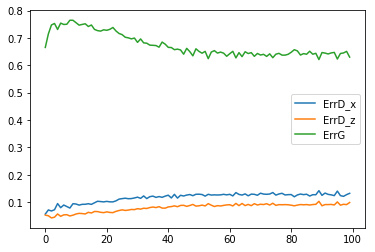

In [26]:
plt.plot(ERRD_x, label='ErrD_x')
plt.plot(ERRD_z, label='ErrD_z')
plt.plot(ERRG, label='ErrG')
plt.legend()
plt.show()

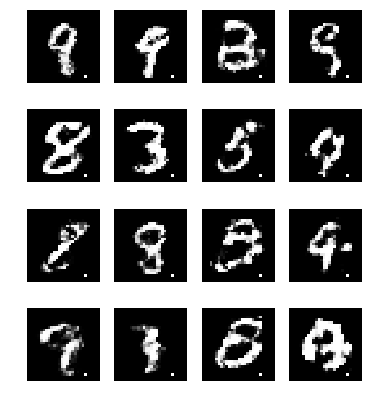

In [36]:
noise.data.normal_(0, 1)
fake = generator(noise)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

### CelebA

In [2]:
class Config:
    pass

config = Config()
config.mnist_path = None
config.batch_size = 16
config.num_workers = 3
config.num_epochs = 10
config.noise_size = 50
config.print_freq = 100

In [3]:
dataset = torchvision.datasets.ImageFolder(root='./CelebA/celeba-dataset',
                      transform=torchvision.transforms.Compose([
                          torchvision.transforms.ToTensor(),]))

dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=config.batch_size, shuffle=True, num_workers=config.num_workers)

In [4]:
len(dataloader)

625

In [5]:
for image, cat in dataloader:
    break

In [6]:
image.size()

torch.Size([16, 3, 218, 178])

In [7]:
218 * 178

38804

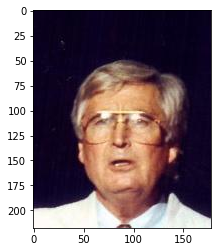

In [9]:
plt.imshow(image[0].permute(1, 2, 0).numpy())

In [10]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential( 
            nn.Linear(config.noise_size, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 218 * 178 * 3),
            nn.Sigmoid())
        
    def forward(self, x):
        return self.model(x)
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(218 * 178 * 3, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1), 
            nn.Sigmoid())
    def forward(self, x):
        return self.model(x)

In [11]:
generator = Generator()
discriminator = Discriminator()

optim_G = optim.Adam(params=generator.parameters(), lr=0.0001)
optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001)

criterion = nn.BCELoss()

input = Variable(torch.FloatTensor(config.batch_size, 218 * 178 * 3))
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size))
fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1))
label = Variable(torch.FloatTensor(config.batch_size))
real_label = 1
fake_label = 0

ERRD_x = np.zeros(config.num_epochs)
ERRD_z = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
N = len(dataloader)

for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        ####### 
        # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z))) 
        #######
        discriminator.zero_grad()
        
        # real
        label.data.fill_(real_label)
        input.data.copy_(images.resize_(218 * 178 * 3))
        output = discriminator(input)
        errD_x = criterion(output, label)
        ERRD_x[epoch] += errD_x.item()
        errD_x.backward()
        
        # fake 
        noise.data.normal_(0, 1)
        fake = generator(noise)
        label.data.fill_(fake_label)
        output = discriminator(fake.detach())
        errD_z = criterion(output, label)
        ERRD_z[epoch] += errD_z.item()
        errD_z.backward()
        
        optim_D.step()
        
        ####### 
        # Generator stage: maximize log(D(G(x))
        #######
        generator.zero_grad()
        label.data.fill_(real_label)
        output = discriminator(fake)
        errG = criterion(output, label)
        ERRG[epoch] += errG.item()
        errG.backward()
        
        optim_G.step()
        
        if (iteration+1) % config.print_freq == 0:
            print('Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(epoch+1,
                                                                                            iteration+1, 
                                                                                            errD_x.item(),
                                                                                            errD_z.item(), 
                                                                                            errG.item()))
ERRD_x /= N
ERRD_z /= N
ERRG /= N

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Epoch:1 Iter: 100 errD_x: 0.02 errD_z: 0.81 errG: 0.98
Epoch:1 Iter: 200 errD_x: 0.19 errD_z: 1.06 errG: 0.39
Epoch:1 Iter: 300 errD_x: 0.38 errD_z: 0.45 errG: 0.95
Epoch:1 Iter: 400 errD_x: 2.20 errD_z: 0.14 errG: 1.93
Epoch:1 Iter: 500 errD_x: 0.00 errD_z: 0.59 errG: 0.64
Epoch:1 Iter: 600 errD_x: 0.46 errD_z: 0.02 errG: 3.78
Epoch:2 Iter: 100 errD_x: 1.03 errD_z: 0.55 errG: 0.93
Epoch:2 Iter: 200 errD_x: 1.41 errD_z: 0.18 errG: 1.70
Epoch:2 Iter: 300 errD_x: 0.13 errD_z: 0.20 errG: 1.56
Epoch:2 Iter: 400 errD_x: 0.13 errD_z: 0.09 errG: 2.35
Epoch:2 Iter: 500 errD_x: 0.00 errD_z: 0.08 errG: 2.48
Epoch:2 Iter: 600 errD_x: 0.00 errD_z: 0.70 errG: 1.13
Epoch:3 Iter: 100 errD_x: 1.06 errD_z: 0.33 errG: 1.25
Epoch:3 Iter: 200 errD_x: 0.00 errD_z: 0.88 errG: 0.65
Epoch:3 Iter: 300 errD_x: 0.00 errD_z: 0.10 errG: 2.58
Epoch:3 Iter: 400 errD_x: 0.00 errD_z: 0.61 errG: 0.92
Epoch:3 Iter: 500 errD_x: 0.00 errD_z: 0.56 errG: 1.15
Epoch:3 Iter: 600 errD_x: 0.25 errD_z: 0.47 errG: 1.23
Epoch:4 It

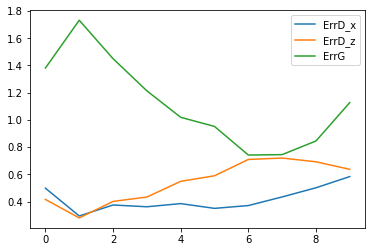

In [12]:
plt.plot(ERRD_x, label='ErrD_x')
plt.plot(ERRD_z, label='ErrD_z')
plt.plot(ERRG, label='ErrG')
plt.legend()
plt.show()

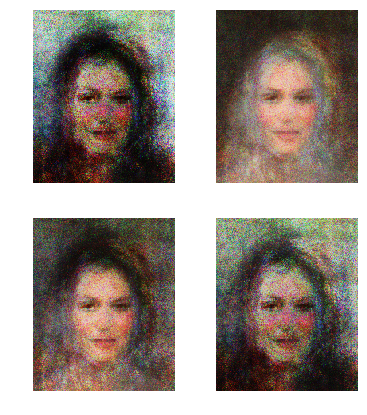

In [20]:
noise.data.normal_(0, 1)
fake = generator(noise)

plt.figure(figsize=(6, 7))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.imshow(np.transpose(fake[i].detach().numpy().reshape(3, 218, 178), (1, 2, 0)),
               cmap=plt.cm.Greys_r)
    plt.axis('off')

In [23]:
generator = Generator()
discriminator = Discriminator()

optim_G = optim.Adam(params=generator.parameters(), lr=0.0001)
optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001)

criterion = nn.MSELoss()

input = Variable(torch.FloatTensor(config.batch_size, 218 * 178 * 3))
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size))
fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1))
label = Variable(torch.FloatTensor(config.batch_size))
real_label = 1
fake_label = 0

ERRD_x = np.zeros(config.num_epochs)
ERRD_z = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
N = len(dataloader)

for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        ####### 
        # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z))) 
        #######
        discriminator.zero_grad()

        # real
        label.data.fill_(real_label)
        input.data.copy_(images.resize_(218 * 178 * 3))
        output = discriminator(input)
        errD_x = criterion(output[:, 0], label)
        ERRD_x[epoch] += errD_x.item()
        errD_x.backward()

        # fake 
        noise.data.normal_(0, 1)
        fake = generator(noise)
        label.data.fill_(fake_label)
        output = discriminator(fake.detach())
        errD_z = criterion(output[:, 0], label)
        ERRD_z[epoch] += errD_z.item()
        errD_z.backward()

        optim_D.step()
        
        ####### 
        # Generator stage: maximize log(D(G(x))
        #######
        generator.zero_grad()
        label.data.fill_(real_label)
        output = discriminator(fake)
        errG = criterion(output[:, 0], label)
        ERRG[epoch] += errG.item()
        errG.backward()
        
        optim_G.step()
        
        if (iteration+1) % config.print_freq == 0:
            print('Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(epoch+1,
                                                                                            iteration+1, 
                                                                                            errD_x.item(),
                                                                                            errD_z.item(), 
                                                                                            errG.item()))
ERRD_x /= N
ERRD_z /= N
ERRG /= N

Epoch:1 Iter: 100 errD_x: 0.00 errD_z: 0.24 errG: 0.37
Epoch:1 Iter: 200 errD_x: 1.00 errD_z: 0.00 errG: 1.00
Epoch:1 Iter: 300 errD_x: 0.05 errD_z: 0.08 errG: 0.40
Epoch:1 Iter: 400 errD_x: 1.00 errD_z: 0.01 errG: 0.90
Epoch:1 Iter: 500 errD_x: 0.49 errD_z: 0.06 errG: 0.61
Epoch:1 Iter: 600 errD_x: 0.00 errD_z: 0.38 errG: 0.25
Epoch:2 Iter: 100 errD_x: 0.00 errD_z: 0.09 errG: 0.57
Epoch:2 Iter: 200 errD_x: 0.00 errD_z: 0.03 errG: 0.77
Epoch:2 Iter: 300 errD_x: 0.00 errD_z: 0.01 errG: 0.88
Epoch:2 Iter: 400 errD_x: 0.00 errD_z: 0.01 errG: 0.81
Epoch:2 Iter: 500 errD_x: 0.21 errD_z: 0.23 errG: 0.47
Epoch:2 Iter: 600 errD_x: 0.00 errD_z: 0.09 errG: 0.61
Epoch:3 Iter: 100 errD_x: 0.06 errD_z: 0.09 errG: 0.56
Epoch:3 Iter: 200 errD_x: 0.00 errD_z: 0.11 errG: 0.51
Epoch:3 Iter: 300 errD_x: 0.04 errD_z: 0.09 errG: 0.60
Epoch:3 Iter: 400 errD_x: 0.00 errD_z: 0.06 errG: 0.56
Epoch:3 Iter: 500 errD_x: 0.00 errD_z: 0.17 errG: 0.43
Epoch:3 Iter: 600 errD_x: 0.04 errD_z: 0.06 errG: 0.69
Epoch:4 It

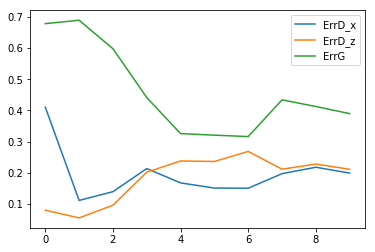

In [24]:
plt.plot(ERRD_x, label='ErrD_x')
plt.plot(ERRD_z, label='ErrD_z')
plt.plot(ERRG, label='ErrG')
plt.legend()
plt.show()

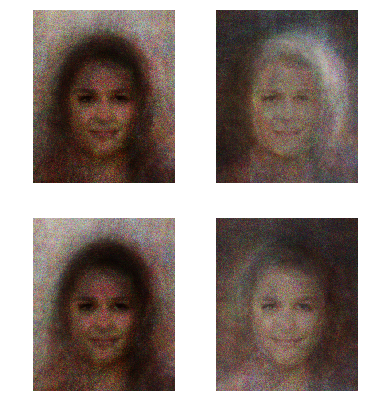

In [28]:
noise.data.normal_(0, 1)
fake = generator(noise)

plt.figure(figsize=(6, 7))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.imshow(np.transpose(fake[i].detach().numpy().reshape(3, 218, 178), (1, 2, 0)),
               cmap=plt.cm.Greys_r)
    plt.axis('off')

In [29]:
generator = Generator()
discriminator = Discriminator()

optim_G = optim.Adam(params=generator.parameters(), lr=0.0001)
optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001)

criterion = nn.MSELoss()

input = Variable(torch.FloatTensor(config.batch_size, 218 * 178 * 3))
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size))
fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1))
label = Variable(torch.FloatTensor(config.batch_size))
real_label = 1
fake_label = 0

ERRD_x = np.zeros(config.num_epochs)
ERRD_z = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
N = len(dataloader)

for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        noise.data.normal_(0, 1)
        fake = generator(noise)
        ####### 
        # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z))) 
        #######
        if iteration % 10 == 0:
            discriminator.zero_grad()

            # real
            label.data.fill_(real_label)
            input.data.copy_(images.resize_(218 * 178 * 3))
            output = discriminator(input)
            errD_x = criterion(output[:, 0], label)
            ERRD_x[epoch] += errD_x.item()
            errD_x.backward()

            # fake 
            label.data.fill_(fake_label)
            output = discriminator(fake.detach())
            errD_z = criterion(output[:, 0], label)
            ERRD_z[epoch] += errD_z.item()
            errD_z.backward()

            optim_D.step()
        
        ####### 
        # Generator stage: maximize log(D(G(x))
        #######
        generator.zero_grad()
        label.data.fill_(real_label)
        output = discriminator(fake)
        errG = criterion(output[:, 0], label)
        ERRG[epoch] += errG.item()
        errG.backward()
        
        optim_G.step()
        
        if (iteration+1) % config.print_freq == 0:
            print('Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(epoch+1,
                                                                                            iteration+1, 
                                                                                            errD_x.item(),
                                                                                            errD_z.item(), 
                                                                                            errG.item()))
ERRD_x /= N
ERRD_z /= N
ERRG /= N

Epoch:1 Iter: 100 errD_x: 0.70 errD_z: 0.07 errG: 0.56
Epoch:1 Iter: 200 errD_x: 0.01 errD_z: 0.56 errG: 0.18
Epoch:1 Iter: 300 errD_x: 0.79 errD_z: 0.02 errG: 0.61
Epoch:1 Iter: 400 errD_x: 1.00 errD_z: 0.01 errG: 0.89
Epoch:1 Iter: 500 errD_x: 0.70 errD_z: 0.24 errG: 0.27
Epoch:1 Iter: 600 errD_x: 1.00 errD_z: 0.00 errG: 0.97
Epoch:2 Iter: 100 errD_x: 0.00 errD_z: 0.38 errG: 0.26
Epoch:2 Iter: 200 errD_x: 0.88 errD_z: 0.47 errG: 0.12
Epoch:2 Iter: 300 errD_x: 0.99 errD_z: 0.01 errG: 0.73
Epoch:2 Iter: 400 errD_x: 0.64 errD_z: 0.23 errG: 0.16
Epoch:2 Iter: 500 errD_x: 1.00 errD_z: 0.00 errG: 1.00
Epoch:2 Iter: 600 errD_x: 1.00 errD_z: 0.00 errG: 1.00
Epoch:3 Iter: 100 errD_x: 1.00 errD_z: 0.00 errG: 1.00
Epoch:3 Iter: 200 errD_x: 1.00 errD_z: 0.00 errG: 1.00
Epoch:3 Iter: 300 errD_x: 1.00 errD_z: 0.00 errG: 1.00
Epoch:3 Iter: 400 errD_x: 1.00 errD_z: 0.00 errG: 1.00
Epoch:3 Iter: 500 errD_x: 1.00 errD_z: 0.00 errG: 1.00
Epoch:3 Iter: 600 errD_x: 1.00 errD_z: 0.00 errG: 1.00
Epoch:4 It

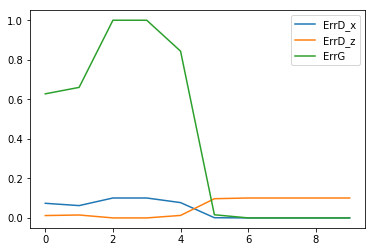

In [30]:
plt.plot(ERRD_x, label='ErrD_x')
plt.plot(ERRD_z, label='ErrD_z')
plt.plot(ERRG, label='ErrG')
plt.legend()
plt.show()

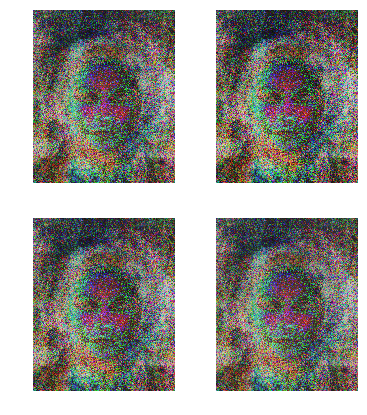

In [31]:
noise.data.normal_(0, 1)
fake = generator(noise)

plt.figure(figsize=(6, 7))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.imshow(np.transpose(fake[i].detach().numpy().reshape(3, 218, 178), (1, 2, 0)),
               cmap=plt.cm.Greys_r)
    plt.axis('off')